In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 468)
(3944610, 8)
validation
(464344, 468)
(464344, 8)
test
(574820, 468)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:31 - loss: 2.3826 - STD: 0.1151 - MAE: 0.2184

  4/395 [..............................] - ETA: 6s - loss: 2.1601 - STD: 0.0621 - MAE: 0.2173   

  7/395 [..............................] - ETA: 6s - loss: 2.1285 - STD: 0.0556 - MAE: 0.2169

 10/395 [..............................] - ETA: 6s - loss: 2.1184 - STD: 0.0532 - MAE: 0.2167

 13/395 [..............................] - ETA: 6s - loss: 2.1068 - STD: 0.0511 - MAE: 0.2166

 16/395 [>.............................] - ETA: 6s - loss: 2.0967 - STD: 0.0485 - MAE: 0.2166

 19/395 [>.............................] - ETA: 6s - loss: 2.0903 - STD: 0.0458 - MAE: 0.2166

 22/395 [>.............................] - ETA: 6s - loss: 2.0863 - STD: 0.0435 - MAE: 0.2167

 25/395 [>.............................] - ETA: 6s - loss: 2.0825 - STD: 0.0419 - MAE: 0.2167

 28/395 [=>............................] - ETA: 6s - loss: 2.0792 - STD: 0.0412 - MAE: 0.2167

 31/395 [=>............................] - ETA: 6s - loss: 2.0764 - STD: 0.0406 - MAE: 0.2167

 34/395 [=>............................] - ETA: 6s - loss: 2.0741 - STD: 0.0398 - MAE: 0.2167

 37/395 [=>............................] - ETA: 6s - loss: 2.0720 - STD: 0.0393 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 6s - loss: 2.0702 - STD: 0.0390 - MAE: 0.2167

 43/395 [==>...........................] - ETA: 6s - loss: 2.0683 - STD: 0.0385 - MAE: 0.2166

 46/395 [==>...........................] - ETA: 6s - loss: 2.0663 - STD: 0.0379 - MAE: 0.2166

 49/395 [==>...........................] - ETA: 5s - loss: 2.0642 - STD: 0.0375 - MAE: 0.2166

 52/395 [==>...........................] - ETA: 5s - loss: 2.0615 - STD: 0.0371 - MAE: 0.2165

 55/395 [===>..........................] - ETA: 5s - loss: 2.0581 - STD: 0.0371 - MAE: 0.2164

 58/395 [===>..........................] - ETA: 5s - loss: 2.0541 - STD: 0.0373 - MAE: 0.2163

 61/395 [===>..........................] - ETA: 5s - loss: 2.0494 - STD: 0.0378 - MAE: 0.2161

 64/395 [===>..........................] - ETA: 5s - loss: 2.0440 - STD: 0.0384 - MAE: 0.2158

 67/395 [====>.........................] - ETA: 5s - loss: 2.0379 - STD: 0.0394 - MAE: 0.2156

 70/395 [====>.........................] - ETA: 5s - loss: 2.0315 - STD: 0.0405 - MAE: 0.2152

 73/395 [====>.........................] - ETA: 5s - loss: 2.0246 - STD: 0.0417 - MAE: 0.2149

 76/395 [====>.........................] - ETA: 5s - loss: 2.0175 - STD: 0.0429 - MAE: 0.2145

 79/395 [=====>........................] - ETA: 5s - loss: 2.0100 - STD: 0.0443 - MAE: 0.2141

 82/395 [=====>........................] - ETA: 5s - loss: 2.0022 - STD: 0.0457 - MAE: 0.2137

 85/395 [=====>........................] - ETA: 5s - loss: 1.9945 - STD: 0.0472 - MAE: 0.2133

 88/395 [=====>........................] - ETA: 5s - loss: 1.9866 - STD: 0.0486 - MAE: 0.2129

 91/395 [=====>........................] - ETA: 5s - loss: 1.9785 - STD: 0.0500 - MAE: 0.2125

 94/395 [======>.......................] - ETA: 5s - loss: 1.9704 - STD: 0.0513 - MAE: 0.2120

 98/395 [======>.......................] - ETA: 5s - loss: 1.9591 - STD: 0.0532 - MAE: 0.2114

101/395 [======>.......................] - ETA: 5s - loss: 1.9503 - STD: 0.0547 - MAE: 0.2109

105/395 [======>.......................] - ETA: 4s - loss: 1.9380 - STD: 0.0566 - MAE: 0.2102

109/395 [=======>......................] - ETA: 4s - loss: 1.9251 - STD: 0.0586 - MAE: 0.2095

112/395 [=======>......................] - ETA: 4s - loss: 1.9153 - STD: 0.0601 - MAE: 0.2089

115/395 [=======>......................] - ETA: 4s - loss: 1.9054 - STD: 0.0617 - MAE: 0.2084

118/395 [=======>......................] - ETA: 4s - loss: 1.8956 - STD: 0.0633 - MAE: 0.2078

121/395 [========>.....................] - ETA: 6s - loss: 1.8878 - STD: 0.0648 - MAE: 0.2072

124/395 [========>.....................] - ETA: 6s - loss: 1.8787 - STD: 0.0664 - MAE: 0.2066

127/395 [========>.....................] - ETA: 6s - loss: 1.8694 - STD: 0.0679 - MAE: 0.2060

130/395 [========>.....................] - ETA: 6s - loss: 1.8605 - STD: 0.0694 - MAE: 0.2054

133/395 [=========>....................] - ETA: 6s - loss: 1.8518 - STD: 0.0709 - MAE: 0.2049

136/395 [=========>....................] - ETA: 6s - loss: 1.8433 - STD: 0.0723 - MAE: 0.2043

139/395 [=========>....................] - ETA: 5s - loss: 1.8352 - STD: 0.0737 - MAE: 0.2038

142/395 [=========>....................] - ETA: 5s - loss: 1.8274 - STD: 0.0750 - MAE: 0.2033

145/395 [==========>...................] - ETA: 5s - loss: 1.8197 - STD: 0.0762 - MAE: 0.2028

148/395 [==========>...................] - ETA: 5s - loss: 1.8124 - STD: 0.0774 - MAE: 0.2024

151/395 [==========>...................] - ETA: 5s - loss: 1.8052 - STD: 0.0786 - MAE: 0.2019

154/395 [==========>...................] - ETA: 5s - loss: 1.7982 - STD: 0.0798 - MAE: 0.2014

157/395 [==========>...................] - ETA: 5s - loss: 1.7913 - STD: 0.0809 - MAE: 0.2010

160/395 [===========>..................] - ETA: 5s - loss: 1.7847 - STD: 0.0820 - MAE: 0.2005

163/395 [===========>..................] - ETA: 5s - loss: 1.7781 - STD: 0.0831 - MAE: 0.2001

166/395 [===========>..................] - ETA: 5s - loss: 1.7717 - STD: 0.0841 - MAE: 0.1997

169/395 [===========>..................] - ETA: 4s - loss: 1.7655 - STD: 0.0852 - MAE: 0.1992

172/395 [============>.................] - ETA: 4s - loss: 1.7593 - STD: 0.0861 - MAE: 0.1988

175/395 [============>.................] - ETA: 4s - loss: 1.7533 - STD: 0.0871 - MAE: 0.1984

178/395 [============>.................] - ETA: 4s - loss: 1.7473 - STD: 0.0881 - MAE: 0.1980

182/395 [============>.................] - ETA: 4s - loss: 1.7397 - STD: 0.0894 - MAE: 0.1975

185/395 [=============>................] - ETA: 4s - loss: 1.7341 - STD: 0.0903 - MAE: 0.1971

189/395 [=============>................] - ETA: 4s - loss: 1.7269 - STD: 0.0915 - MAE: 0.1966

192/395 [=============>................] - ETA: 4s - loss: 1.7215 - STD: 0.0924 - MAE: 0.1962

195/395 [=============>................] - ETA: 4s - loss: 1.7162 - STD: 0.0932 - MAE: 0.1958

198/395 [==============>...............] - ETA: 4s - loss: 1.7112 - STD: 0.0941 - MAE: 0.1955

201/395 [==============>...............] - ETA: 4s - loss: 1.7061 - STD: 0.0949 - MAE: 0.1951

204/395 [==============>...............] - ETA: 4s - loss: 1.7014 - STD: 0.0957 - MAE: 0.1947

207/395 [==============>...............] - ETA: 3s - loss: 1.6965 - STD: 0.0965 - MAE: 0.1944

210/395 [==============>...............] - ETA: 3s - loss: 1.6917 - STD: 0.0973 - MAE: 0.1940

214/395 [===============>..............] - ETA: 3s - loss: 1.6855 - STD: 0.0983 - MAE: 0.1936

217/395 [===============>..............] - ETA: 3s - loss: 1.6810 - STD: 0.0991 - MAE: 0.1933

220/395 [===============>..............] - ETA: 3s - loss: 1.6766 - STD: 0.0998 - MAE: 0.1929

223/395 [===============>..............] - ETA: 3s - loss: 1.6722 - STD: 0.1006 - MAE: 0.1926

226/395 [================>.............] - ETA: 3s - loss: 1.6678 - STD: 0.1013 - MAE: 0.1923

229/395 [================>.............] - ETA: 3s - loss: 1.6637 - STD: 0.1020 - MAE: 0.1919

232/395 [================>.............] - ETA: 3s - loss: 1.6594 - STD: 0.1027 - MAE: 0.1916

235/395 [================>.............] - ETA: 3s - loss: 1.6553 - STD: 0.1034 - MAE: 0.1913

238/395 [=================>............] - ETA: 3s - loss: 1.6514 - STD: 0.1041 - MAE: 0.1910

241/395 [=================>............] - ETA: 3s - loss: 1.6473 - STD: 0.1048 - MAE: 0.1907

244/395 [=================>............] - ETA: 3s - loss: 1.6433 - STD: 0.1054 - MAE: 0.1904

247/395 [=================>............] - ETA: 3s - loss: 1.6396 - STD: 0.1061 - MAE: 0.1901

250/395 [=================>............] - ETA: 2s - loss: 1.6359 - STD: 0.1067 - MAE: 0.1898

253/395 [==================>...........] - ETA: 2s - loss: 1.6321 - STD: 0.1074 - MAE: 0.1895

256/395 [==================>...........] - ETA: 2s - loss: 1.6285 - STD: 0.1080 - MAE: 0.1892

259/395 [==================>...........] - ETA: 2s - loss: 1.6249 - STD: 0.1086 - MAE: 0.1890

262/395 [==================>...........] - ETA: 2s - loss: 1.6214 - STD: 0.1092 - MAE: 0.1887

265/395 [===================>..........] - ETA: 2s - loss: 1.6181 - STD: 0.1098 - MAE: 0.1884

269/395 [===================>..........] - ETA: 2s - loss: 1.6137 - STD: 0.1106 - MAE: 0.1881

272/395 [===================>..........] - ETA: 2s - loss: 1.6102 - STD: 0.1111 - MAE: 0.1878

275/395 [===================>..........] - ETA: 2s - loss: 1.6069 - STD: 0.1117 - MAE: 0.1875

278/395 [====================>.........] - ETA: 2s - loss: 1.6037 - STD: 0.1123 - MAE: 0.1873

281/395 [====================>.........] - ETA: 2s - loss: 1.6004 - STD: 0.1128 - MAE: 0.1870

284/395 [====================>.........] - ETA: 2s - loss: 1.5971 - STD: 0.1134 - MAE: 0.1867

287/395 [====================>.........] - ETA: 2s - loss: 1.5939 - STD: 0.1139 - MAE: 0.1865

290/395 [=====================>........] - ETA: 2s - loss: 1.5907 - STD: 0.1145 - MAE: 0.1862

293/395 [=====================>........] - ETA: 2s - loss: 1.5877 - STD: 0.1150 - MAE: 0.1860

296/395 [=====================>........] - ETA: 1s - loss: 1.5846 - STD: 0.1155 - MAE: 0.1857

300/395 [=====================>........] - ETA: 1s - loss: 1.5805 - STD: 0.1162 - MAE: 0.1854

303/395 [======================>.......] - ETA: 1s - loss: 1.5776 - STD: 0.1167 - MAE: 0.1851

306/395 [======================>.......] - ETA: 1s - loss: 1.5746 - STD: 0.1172 - MAE: 0.1849

309/395 [======================>.......] - ETA: 1s - loss: 1.5716 - STD: 0.1177 - MAE: 0.1847

312/395 [======================>.......] - ETA: 1s - loss: 1.5687 - STD: 0.1182 - MAE: 0.1844

315/395 [======================>.......] - ETA: 1s - loss: 1.5660 - STD: 0.1187 - MAE: 0.1842

318/395 [=======================>......] - ETA: 1s - loss: 1.5631 - STD: 0.1192 - MAE: 0.1839

321/395 [=======================>......] - ETA: 1s - loss: 1.5605 - STD: 0.1197 - MAE: 0.1837

324/395 [=======================>......] - ETA: 1s - loss: 1.5577 - STD: 0.1201 - MAE: 0.1835

327/395 [=======================>......] - ETA: 1s - loss: 1.5550 - STD: 0.1206 - MAE: 0.1833

330/395 [========================>.....] - ETA: 1s - loss: 1.5522 - STD: 0.1211 - MAE: 0.1830

333/395 [========================>.....] - ETA: 1s - loss: 1.5496 - STD: 0.1215 - MAE: 0.1828

336/395 [========================>.....] - ETA: 1s - loss: 1.5471 - STD: 0.1220 - MAE: 0.1826

339/395 [========================>.....] - ETA: 1s - loss: 1.5446 - STD: 0.1224 - MAE: 0.1824

343/395 [=========================>....] - ETA: 1s - loss: 1.5413 - STD: 0.1230 - MAE: 0.1821

346/395 [=========================>....] - ETA: 0s - loss: 1.5389 - STD: 0.1235 - MAE: 0.1819

350/395 [=========================>....] - ETA: 0s - loss: 1.5356 - STD: 0.1240 - MAE: 0.1816

354/395 [=========================>....] - ETA: 0s - loss: 1.5323 - STD: 0.1246 - MAE: 0.1813

357/395 [==========================>...] - ETA: 0s - loss: 1.5298 - STD: 0.1250 - MAE: 0.1811

360/395 [==========================>...] - ETA: 0s - loss: 1.5274 - STD: 0.1254 - MAE: 0.1809

363/395 [==========================>...] - ETA: 0s - loss: 1.5250 - STD: 0.1258 - MAE: 0.1807

366/395 [==========================>...] - ETA: 0s - loss: 1.5226 - STD: 0.1262 - MAE: 0.1805

369/395 [===========================>..] - ETA: 0s - loss: 1.5203 - STD: 0.1266 - MAE: 0.1803

372/395 [===========================>..] - ETA: 0s - loss: 1.5180 - STD: 0.1270 - MAE: 0.1801

375/395 [===========================>..] - ETA: 0s - loss: 1.5159 - STD: 0.1274 - MAE: 0.1799

378/395 [===========================>..] - ETA: 0s - loss: 1.5138 - STD: 0.1278 - MAE: 0.1797

381/395 [===========================>..] - ETA: 0s - loss: 1.5116 - STD: 0.1282 - MAE: 0.1795

384/395 [============================>.] - ETA: 0s - loss: 1.5096 - STD: 0.1285 - MAE: 0.1794

387/395 [============================>.] - ETA: 0s - loss: 1.5075 - STD: 0.1289 - MAE: 0.1792

390/395 [============================>.] - ETA: 0s - loss: 1.5054 - STD: 0.1293 - MAE: 0.1790

393/395 [============================>.] - ETA: 0s - loss: 1.5034 - STD: 0.1296 - MAE: 0.1788

395/395 [==============================] - 10s 22ms/step - loss: 1.5020 - STD: 0.1299 - MAE: 0.1787 - val_loss: 1.2309 - val_STD: 0.1760 - val_MAE: 0.1541


Epoch 2/10000


  1/395 [..............................] - ETA: 14s - loss: 1.2302 - STD: 0.1760 - MAE: 0.1553

  4/395 [..............................] - ETA: 6s - loss: 1.2341 - STD: 0.1763 - MAE: 0.1554 

  7/395 [..............................] - ETA: 6s - loss: 1.2293 - STD: 0.1766 - MAE: 0.1550

 10/395 [..............................] - ETA: 6s - loss: 1.2292 - STD: 0.1766 - MAE: 0.1549

 13/395 [..............................] - ETA: 6s - loss: 1.2290 - STD: 0.1767 - MAE: 0.1549

 16/395 [>.............................] - ETA: 6s - loss: 1.2286 - STD: 0.1769 - MAE: 0.1548

 19/395 [>.............................] - ETA: 6s - loss: 1.2260 - STD: 0.1772 - MAE: 0.1546

 22/395 [>.............................] - ETA: 6s - loss: 1.2249 - STD: 0.1775 - MAE: 0.1544

 25/395 [>.............................] - ETA: 6s - loss: 1.2238 - STD: 0.1777 - MAE: 0.1544

 28/395 [=>............................] - ETA: 6s - loss: 1.2224 - STD: 0.1778 - MAE: 0.1542

 31/395 [=>............................] - ETA: 6s - loss: 1.2213 - STD: 0.1780 - MAE: 0.1541

 34/395 [=>............................] - ETA: 6s - loss: 1.2203 - STD: 0.1781 - MAE: 0.1540

 37/395 [=>............................] - ETA: 6s - loss: 1.2192 - STD: 0.1783 - MAE: 0.1539

 40/395 [==>...........................] - ETA: 6s - loss: 1.2194 - STD: 0.1783 - MAE: 0.1539

 43/395 [==>...........................] - ETA: 6s - loss: 1.2181 - STD: 0.1784 - MAE: 0.1538

 46/395 [==>...........................] - ETA: 5s - loss: 1.2185 - STD: 0.1785 - MAE: 0.1538

 49/395 [==>...........................] - ETA: 5s - loss: 1.2180 - STD: 0.1786 - MAE: 0.1537

 52/395 [==>...........................] - ETA: 5s - loss: 1.2177 - STD: 0.1787 - MAE: 0.1537

 55/395 [===>..........................] - ETA: 5s - loss: 1.2173 - STD: 0.1787 - MAE: 0.1536

 58/395 [===>..........................] - ETA: 5s - loss: 1.2168 - STD: 0.1788 - MAE: 0.1536

 62/395 [===>..........................] - ETA: 5s - loss: 1.2159 - STD: 0.1790 - MAE: 0.1535

 65/395 [===>..........................] - ETA: 5s - loss: 1.2152 - STD: 0.1791 - MAE: 0.1534

 68/395 [====>.........................] - ETA: 5s - loss: 1.2152 - STD: 0.1791 - MAE: 0.1534

 72/395 [====>.........................] - ETA: 5s - loss: 1.2145 - STD: 0.1793 - MAE: 0.1533

 75/395 [====>.........................] - ETA: 5s - loss: 1.2137 - STD: 0.1793 - MAE: 0.1533

 78/395 [====>.........................] - ETA: 5s - loss: 1.2130 - STD: 0.1794 - MAE: 0.1532

 81/395 [=====>........................] - ETA: 5s - loss: 1.2124 - STD: 0.1795 - MAE: 0.1531

 84/395 [=====>........................] - ETA: 5s - loss: 1.2117 - STD: 0.1796 - MAE: 0.1531

 87/395 [=====>........................] - ETA: 5s - loss: 1.2111 - STD: 0.1797 - MAE: 0.1530

 90/395 [=====>........................] - ETA: 5s - loss: 1.2105 - STD: 0.1798 - MAE: 0.1529

 93/395 [======>.......................] - ETA: 5s - loss: 1.2104 - STD: 0.1799 - MAE: 0.1529

 96/395 [======>.......................] - ETA: 5s - loss: 1.2097 - STD: 0.1800 - MAE: 0.1528

 99/395 [======>.......................] - ETA: 5s - loss: 1.2093 - STD: 0.1800 - MAE: 0.1528

102/395 [======>.......................] - ETA: 4s - loss: 1.2088 - STD: 0.1801 - MAE: 0.1527

105/395 [======>.......................] - ETA: 4s - loss: 1.2085 - STD: 0.1802 - MAE: 0.1527

108/395 [=======>......................] - ETA: 4s - loss: 1.2084 - STD: 0.1803 - MAE: 0.1526

111/395 [=======>......................] - ETA: 4s - loss: 1.2081 - STD: 0.1803 - MAE: 0.1526

114/395 [=======>......................] - ETA: 4s - loss: 1.2079 - STD: 0.1804 - MAE: 0.1526

117/395 [=======>......................] - ETA: 4s - loss: 1.2075 - STD: 0.1805 - MAE: 0.1525

120/395 [========>.....................] - ETA: 4s - loss: 1.2072 - STD: 0.1805 - MAE: 0.1525

123/395 [========>.....................] - ETA: 4s - loss: 1.2065 - STD: 0.1806 - MAE: 0.1524

126/395 [========>.....................] - ETA: 4s - loss: 1.2059 - STD: 0.1806 - MAE: 0.1524

129/395 [========>.....................] - ETA: 4s - loss: 1.2054 - STD: 0.1807 - MAE: 0.1523

132/395 [=========>....................] - ETA: 4s - loss: 1.2050 - STD: 0.1808 - MAE: 0.1523

136/395 [=========>....................] - ETA: 4s - loss: 1.2043 - STD: 0.1809 - MAE: 0.1522

139/395 [=========>....................] - ETA: 4s - loss: 1.2040 - STD: 0.1809 - MAE: 0.1522

142/395 [=========>....................] - ETA: 4s - loss: 1.2034 - STD: 0.1810 - MAE: 0.1521

145/395 [==========>...................] - ETA: 4s - loss: 1.2032 - STD: 0.1811 - MAE: 0.1521

148/395 [==========>...................] - ETA: 4s - loss: 1.2029 - STD: 0.1812 - MAE: 0.1520

151/395 [==========>...................] - ETA: 4s - loss: 1.2026 - STD: 0.1812 - MAE: 0.1520

154/395 [==========>...................] - ETA: 4s - loss: 1.2022 - STD: 0.1813 - MAE: 0.1520

157/395 [==========>...................] - ETA: 4s - loss: 1.2017 - STD: 0.1813 - MAE: 0.1519

160/395 [===========>..................] - ETA: 3s - loss: 1.2012 - STD: 0.1814 - MAE: 0.1519

163/395 [===========>..................] - ETA: 3s - loss: 1.2008 - STD: 0.1815 - MAE: 0.1518

166/395 [===========>..................] - ETA: 3s - loss: 1.2006 - STD: 0.1816 - MAE: 0.1518

169/395 [===========>..................] - ETA: 3s - loss: 1.2001 - STD: 0.1816 - MAE: 0.1517

172/395 [============>.................] - ETA: 3s - loss: 1.2001 - STD: 0.1817 - MAE: 0.1517

175/395 [============>.................] - ETA: 3s - loss: 1.1998 - STD: 0.1817 - MAE: 0.1517

178/395 [============>.................] - ETA: 3s - loss: 1.1994 - STD: 0.1818 - MAE: 0.1516

181/395 [============>.................] - ETA: 3s - loss: 1.1991 - STD: 0.1819 - MAE: 0.1516

184/395 [============>.................] - ETA: 3s - loss: 1.1988 - STD: 0.1819 - MAE: 0.1515

187/395 [=============>................] - ETA: 3s - loss: 1.1985 - STD: 0.1820 - MAE: 0.1515

190/395 [=============>................] - ETA: 3s - loss: 1.1984 - STD: 0.1820 - MAE: 0.1515

193/395 [=============>................] - ETA: 3s - loss: 1.1979 - STD: 0.1821 - MAE: 0.1514

196/395 [=============>................] - ETA: 3s - loss: 1.1975 - STD: 0.1821 - MAE: 0.1514

199/395 [==============>...............] - ETA: 3s - loss: 1.1971 - STD: 0.1822 - MAE: 0.1513

202/395 [==============>...............] - ETA: 3s - loss: 1.1967 - STD: 0.1822 - MAE: 0.1513

205/395 [==============>...............] - ETA: 3s - loss: 1.1961 - STD: 0.1823 - MAE: 0.1513

208/395 [==============>...............] - ETA: 3s - loss: 1.1957 - STD: 0.1823 - MAE: 0.1512

211/395 [===============>..............] - ETA: 3s - loss: 1.1951 - STD: 0.1824 - MAE: 0.1512

214/395 [===============>..............] - ETA: 3s - loss: 1.1947 - STD: 0.1825 - MAE: 0.1511

217/395 [===============>..............] - ETA: 3s - loss: 1.1944 - STD: 0.1825 - MAE: 0.1511

220/395 [===============>..............] - ETA: 2s - loss: 1.1938 - STD: 0.1826 - MAE: 0.1510

223/395 [===============>..............] - ETA: 2s - loss: 1.1933 - STD: 0.1827 - MAE: 0.1510

226/395 [================>.............] - ETA: 2s - loss: 1.1929 - STD: 0.1827 - MAE: 0.1509

229/395 [================>.............] - ETA: 2s - loss: 1.1923 - STD: 0.1828 - MAE: 0.1509

232/395 [================>.............] - ETA: 2s - loss: 1.1919 - STD: 0.1828 - MAE: 0.1508

235/395 [================>.............] - ETA: 2s - loss: 1.1915 - STD: 0.1829 - MAE: 0.1508

238/395 [=================>............] - ETA: 2s - loss: 1.1911 - STD: 0.1830 - MAE: 0.1508

241/395 [=================>............] - ETA: 2s - loss: 1.1907 - STD: 0.1830 - MAE: 0.1507

244/395 [=================>............] - ETA: 2s - loss: 1.1904 - STD: 0.1831 - MAE: 0.1507

247/395 [=================>............] - ETA: 2s - loss: 1.1899 - STD: 0.1831 - MAE: 0.1506

250/395 [=================>............] - ETA: 2s - loss: 1.1896 - STD: 0.1832 - MAE: 0.1506

253/395 [==================>...........] - ETA: 2s - loss: 1.1892 - STD: 0.1833 - MAE: 0.1506

256/395 [==================>...........] - ETA: 2s - loss: 1.1887 - STD: 0.1833 - MAE: 0.1505

259/395 [==================>...........] - ETA: 2s - loss: 1.1883 - STD: 0.1834 - MAE: 0.1505

262/395 [==================>...........] - ETA: 2s - loss: 1.1879 - STD: 0.1834 - MAE: 0.1504

265/395 [===================>..........] - ETA: 2s - loss: 1.1874 - STD: 0.1835 - MAE: 0.1504

268/395 [===================>..........] - ETA: 2s - loss: 1.1870 - STD: 0.1835 - MAE: 0.1503

271/395 [===================>..........] - ETA: 2s - loss: 1.1865 - STD: 0.1836 - MAE: 0.1503

274/395 [===================>..........] - ETA: 2s - loss: 1.1860 - STD: 0.1837 - MAE: 0.1502

277/395 [====================>.........] - ETA: 2s - loss: 1.1856 - STD: 0.1837 - MAE: 0.1502

280/395 [====================>.........] - ETA: 1s - loss: 1.1851 - STD: 0.1838 - MAE: 0.1502

283/395 [====================>.........] - ETA: 1s - loss: 1.1847 - STD: 0.1838 - MAE: 0.1501

286/395 [====================>.........] - ETA: 1s - loss: 1.1843 - STD: 0.1839 - MAE: 0.1501

289/395 [====================>.........] - ETA: 1s - loss: 1.1839 - STD: 0.1839 - MAE: 0.1500

292/395 [=====================>........] - ETA: 1s - loss: 1.1833 - STD: 0.1840 - MAE: 0.1500

295/395 [=====================>........] - ETA: 1s - loss: 1.1829 - STD: 0.1840 - MAE: 0.1499

298/395 [=====================>........] - ETA: 1s - loss: 1.1824 - STD: 0.1841 - MAE: 0.1499

301/395 [=====================>........] - ETA: 1s - loss: 1.1821 - STD: 0.1842 - MAE: 0.1499

304/395 [======================>.......] - ETA: 1s - loss: 1.1817 - STD: 0.1842 - MAE: 0.1498

307/395 [======================>.......] - ETA: 1s - loss: 1.1812 - STD: 0.1843 - MAE: 0.1498

310/395 [======================>.......] - ETA: 1s - loss: 1.1807 - STD: 0.1843 - MAE: 0.1497

313/395 [======================>.......] - ETA: 1s - loss: 1.1803 - STD: 0.1844 - MAE: 0.1497

316/395 [=======================>......] - ETA: 1s - loss: 1.1801 - STD: 0.1844 - MAE: 0.1497

319/395 [=======================>......] - ETA: 1s - loss: 1.1798 - STD: 0.1845 - MAE: 0.1496

322/395 [=======================>......] - ETA: 1s - loss: 1.1797 - STD: 0.1845 - MAE: 0.1496

325/395 [=======================>......] - ETA: 1s - loss: 1.1793 - STD: 0.1846 - MAE: 0.1495

328/395 [=======================>......] - ETA: 1s - loss: 1.1790 - STD: 0.1846 - MAE: 0.1495

331/395 [========================>.....] - ETA: 1s - loss: 1.1788 - STD: 0.1847 - MAE: 0.1495

334/395 [========================>.....] - ETA: 1s - loss: 1.1785 - STD: 0.1847 - MAE: 0.1495

337/395 [========================>.....] - ETA: 0s - loss: 1.1781 - STD: 0.1848 - MAE: 0.1494

340/395 [========================>.....] - ETA: 0s - loss: 1.1778 - STD: 0.1848 - MAE: 0.1494

343/395 [=========================>....] - ETA: 0s - loss: 1.1773 - STD: 0.1849 - MAE: 0.1493

346/395 [=========================>....] - ETA: 0s - loss: 1.1770 - STD: 0.1849 - MAE: 0.1493

349/395 [=========================>....] - ETA: 0s - loss: 1.1766 - STD: 0.1850 - MAE: 0.1493

352/395 [=========================>....] - ETA: 0s - loss: 1.1763 - STD: 0.1850 - MAE: 0.1492

355/395 [=========================>....] - ETA: 0s - loss: 1.1759 - STD: 0.1851 - MAE: 0.1492

358/395 [==========================>...] - ETA: 0s - loss: 1.1755 - STD: 0.1851 - MAE: 0.1492

361/395 [==========================>...] - ETA: 0s - loss: 1.1751 - STD: 0.1852 - MAE: 0.1491

364/395 [==========================>...] - ETA: 0s - loss: 1.1748 - STD: 0.1852 - MAE: 0.1491

367/395 [==========================>...] - ETA: 0s - loss: 1.1745 - STD: 0.1853 - MAE: 0.1491

370/395 [===========================>..] - ETA: 0s - loss: 1.1741 - STD: 0.1853 - MAE: 0.1490

373/395 [===========================>..] - ETA: 0s - loss: 1.1738 - STD: 0.1854 - MAE: 0.1490

376/395 [===========================>..] - ETA: 0s - loss: 1.1733 - STD: 0.1854 - MAE: 0.1489

379/395 [===========================>..] - ETA: 0s - loss: 1.1729 - STD: 0.1855 - MAE: 0.1489

382/395 [============================>.] - ETA: 0s - loss: 1.1725 - STD: 0.1855 - MAE: 0.1489

385/395 [============================>.] - ETA: 0s - loss: 1.1720 - STD: 0.1856 - MAE: 0.1488

388/395 [============================>.] - ETA: 0s - loss: 1.1717 - STD: 0.1856 - MAE: 0.1488

391/395 [============================>.] - ETA: 0s - loss: 1.1713 - STD: 0.1857 - MAE: 0.1487

394/395 [============================>.] - ETA: 0s - loss: 1.1709 - STD: 0.1857 - MAE: 0.1487

395/395 [==============================] - 7s 19ms/step - loss: 1.1707 - STD: 0.1857 - MAE: 0.1487 - val_loss: 1.1754 - val_STD: 0.1935 - val_MAE: 0.1439


Epoch 3/10000


  1/395 [..............................] - ETA: 16s - loss: 1.1260 - STD: 0.1924 - MAE: 0.1441

  4/395 [..............................] - ETA: 6s - loss: 1.1230 - STD: 0.1921 - MAE: 0.1438 

  7/395 [..............................] - ETA: 6s - loss: 1.1187 - STD: 0.1922 - MAE: 0.1435

 10/395 [..............................] - ETA: 6s - loss: 1.1171 - STD: 0.1922 - MAE: 0.1435

 13/395 [..............................] - ETA: 6s - loss: 1.1192 - STD: 0.1922 - MAE: 0.1436

 16/395 [>.............................] - ETA: 6s - loss: 1.1179 - STD: 0.1922 - MAE: 0.1435

 19/395 [>.............................] - ETA: 6s - loss: 1.1168 - STD: 0.1922 - MAE: 0.1435

 22/395 [>.............................] - ETA: 6s - loss: 1.1164 - STD: 0.1924 - MAE: 0.1434

 25/395 [>.............................] - ETA: 6s - loss: 1.1164 - STD: 0.1924 - MAE: 0.1434

 28/395 [=>............................] - ETA: 6s - loss: 1.1167 - STD: 0.1925 - MAE: 0.1433

 31/395 [=>............................] - ETA: 6s - loss: 1.1169 - STD: 0.1926 - MAE: 0.1433

 34/395 [=>............................] - ETA: 6s - loss: 1.1171 - STD: 0.1926 - MAE: 0.1433

 37/395 [=>............................] - ETA: 6s - loss: 1.1169 - STD: 0.1927 - MAE: 0.1433

 40/395 [==>...........................] - ETA: 6s - loss: 1.1178 - STD: 0.1927 - MAE: 0.1434

 43/395 [==>...........................] - ETA: 5s - loss: 1.1201 - STD: 0.1927 - MAE: 0.1435

 46/395 [==>...........................] - ETA: 5s - loss: 1.1198 - STD: 0.1927 - MAE: 0.1435

 49/395 [==>...........................] - ETA: 5s - loss: 1.1201 - STD: 0.1927 - MAE: 0.1435

 52/395 [==>...........................] - ETA: 5s - loss: 1.1204 - STD: 0.1926 - MAE: 0.1435

 55/395 [===>..........................] - ETA: 5s - loss: 1.1198 - STD: 0.1926 - MAE: 0.1435

 58/395 [===>..........................] - ETA: 5s - loss: 1.1197 - STD: 0.1926 - MAE: 0.1435

 61/395 [===>..........................] - ETA: 5s - loss: 1.1194 - STD: 0.1926 - MAE: 0.1435

 64/395 [===>..........................] - ETA: 5s - loss: 1.1189 - STD: 0.1926 - MAE: 0.1435

 67/395 [====>.........................] - ETA: 5s - loss: 1.1190 - STD: 0.1926 - MAE: 0.1435

 70/395 [====>.........................] - ETA: 5s - loss: 1.1195 - STD: 0.1927 - MAE: 0.1435

 73/395 [====>.........................] - ETA: 5s - loss: 1.1185 - STD: 0.1927 - MAE: 0.1434

 76/395 [====>.........................] - ETA: 5s - loss: 1.1184 - STD: 0.1927 - MAE: 0.1434

 79/395 [=====>........................] - ETA: 5s - loss: 1.1178 - STD: 0.1927 - MAE: 0.1434

 82/395 [=====>........................] - ETA: 5s - loss: 1.1169 - STD: 0.1928 - MAE: 0.1433

 85/395 [=====>........................] - ETA: 5s - loss: 1.1166 - STD: 0.1929 - MAE: 0.1432

 88/395 [=====>........................] - ETA: 5s - loss: 1.1162 - STD: 0.1929 - MAE: 0.1432

 91/395 [=====>........................] - ETA: 5s - loss: 1.1157 - STD: 0.1929 - MAE: 0.1432

 94/395 [======>.......................] - ETA: 5s - loss: 1.1151 - STD: 0.1930 - MAE: 0.1431

 97/395 [======>.......................] - ETA: 5s - loss: 1.1147 - STD: 0.1930 - MAE: 0.1431

100/395 [======>.......................] - ETA: 5s - loss: 1.1143 - STD: 0.1931 - MAE: 0.1430

103/395 [======>.......................] - ETA: 5s - loss: 1.1138 - STD: 0.1931 - MAE: 0.1430

106/395 [=======>......................] - ETA: 4s - loss: 1.1135 - STD: 0.1932 - MAE: 0.1429

109/395 [=======>......................] - ETA: 4s - loss: 1.1133 - STD: 0.1932 - MAE: 0.1429

112/395 [=======>......................] - ETA: 4s - loss: 1.1126 - STD: 0.1933 - MAE: 0.1429

115/395 [=======>......................] - ETA: 4s - loss: 1.1123 - STD: 0.1933 - MAE: 0.1428

118/395 [=======>......................] - ETA: 4s - loss: 1.1119 - STD: 0.1933 - MAE: 0.1428

121/395 [========>.....................] - ETA: 4s - loss: 1.1116 - STD: 0.1934 - MAE: 0.1428

124/395 [========>.....................] - ETA: 4s - loss: 1.1111 - STD: 0.1934 - MAE: 0.1427

127/395 [========>.....................] - ETA: 4s - loss: 1.1106 - STD: 0.1935 - MAE: 0.1427

130/395 [========>.....................] - ETA: 4s - loss: 1.1101 - STD: 0.1935 - MAE: 0.1426

133/395 [=========>....................] - ETA: 4s - loss: 1.1096 - STD: 0.1936 - MAE: 0.1426

136/395 [=========>....................] - ETA: 4s - loss: 1.1092 - STD: 0.1936 - MAE: 0.1425

139/395 [=========>....................] - ETA: 4s - loss: 1.1088 - STD: 0.1937 - MAE: 0.1425

142/395 [=========>....................] - ETA: 4s - loss: 1.1086 - STD: 0.1937 - MAE: 0.1425

145/395 [==========>...................] - ETA: 4s - loss: 1.1087 - STD: 0.1938 - MAE: 0.1424

148/395 [==========>...................] - ETA: 4s - loss: 1.1084 - STD: 0.1938 - MAE: 0.1424

151/395 [==========>...................] - ETA: 4s - loss: 1.1082 - STD: 0.1939 - MAE: 0.1424

155/395 [==========>...................] - ETA: 4s - loss: 1.1080 - STD: 0.1939 - MAE: 0.1424

159/395 [===========>..................] - ETA: 4s - loss: 1.1077 - STD: 0.1939 - MAE: 0.1423

162/395 [===========>..................] - ETA: 3s - loss: 1.1075 - STD: 0.1940 - MAE: 0.1423

165/395 [===========>..................] - ETA: 3s - loss: 1.1072 - STD: 0.1940 - MAE: 0.1423

169/395 [===========>..................] - ETA: 3s - loss: 1.1068 - STD: 0.1941 - MAE: 0.1422

172/395 [============>.................] - ETA: 3s - loss: 1.1065 - STD: 0.1941 - MAE: 0.1422

175/395 [============>.................] - ETA: 3s - loss: 1.1064 - STD: 0.1941 - MAE: 0.1422

178/395 [============>.................] - ETA: 3s - loss: 1.1063 - STD: 0.1942 - MAE: 0.1422

181/395 [============>.................] - ETA: 3s - loss: 1.1063 - STD: 0.1942 - MAE: 0.1421

184/395 [============>.................] - ETA: 3s - loss: 1.1061 - STD: 0.1942 - MAE: 0.1421

187/395 [=============>................] - ETA: 3s - loss: 1.1058 - STD: 0.1943 - MAE: 0.1421

190/395 [=============>................] - ETA: 3s - loss: 1.1055 - STD: 0.1943 - MAE: 0.1421

193/395 [=============>................] - ETA: 3s - loss: 1.1051 - STD: 0.1944 - MAE: 0.1420

196/395 [=============>................] - ETA: 3s - loss: 1.1047 - STD: 0.1944 - MAE: 0.1420

199/395 [==============>...............] - ETA: 3s - loss: 1.1042 - STD: 0.1944 - MAE: 0.1420

202/395 [==============>...............] - ETA: 3s - loss: 1.1037 - STD: 0.1945 - MAE: 0.1419

205/395 [==============>...............] - ETA: 3s - loss: 1.1034 - STD: 0.1945 - MAE: 0.1419

208/395 [==============>...............] - ETA: 3s - loss: 1.1031 - STD: 0.1945 - MAE: 0.1419

211/395 [===============>..............] - ETA: 3s - loss: 1.1027 - STD: 0.1946 - MAE: 0.1418

214/395 [===============>..............] - ETA: 3s - loss: 1.1023 - STD: 0.1946 - MAE: 0.1418

218/395 [===============>..............] - ETA: 3s - loss: 1.1018 - STD: 0.1947 - MAE: 0.1417

221/395 [===============>..............] - ETA: 2s - loss: 1.1014 - STD: 0.1947 - MAE: 0.1417

224/395 [================>.............] - ETA: 2s - loss: 1.1011 - STD: 0.1948 - MAE: 0.1417

227/395 [================>.............] - ETA: 2s - loss: 1.1008 - STD: 0.1948 - MAE: 0.1416

230/395 [================>.............] - ETA: 2s - loss: 1.1006 - STD: 0.1949 - MAE: 0.1416

233/395 [================>.............] - ETA: 2s - loss: 1.1003 - STD: 0.1949 - MAE: 0.1416

236/395 [================>.............] - ETA: 2s - loss: 1.1001 - STD: 0.1949 - MAE: 0.1415

239/395 [=================>............] - ETA: 2s - loss: 1.0998 - STD: 0.1949 - MAE: 0.1415

242/395 [=================>............] - ETA: 2s - loss: 1.0993 - STD: 0.1950 - MAE: 0.1415

245/395 [=================>............] - ETA: 2s - loss: 1.0990 - STD: 0.1950 - MAE: 0.1414

248/395 [=================>............] - ETA: 2s - loss: 1.0986 - STD: 0.1950 - MAE: 0.1414

251/395 [==================>...........] - ETA: 2s - loss: 1.0982 - STD: 0.1951 - MAE: 0.1414

254/395 [==================>...........] - ETA: 2s - loss: 1.0979 - STD: 0.1951 - MAE: 0.1413

257/395 [==================>...........] - ETA: 2s - loss: 1.0975 - STD: 0.1952 - MAE: 0.1413

261/395 [==================>...........] - ETA: 2s - loss: 1.0971 - STD: 0.1952 - MAE: 0.1413

264/395 [===================>..........] - ETA: 2s - loss: 1.0967 - STD: 0.1952 - MAE: 0.1412

268/395 [===================>..........] - ETA: 2s - loss: 1.0964 - STD: 0.1953 - MAE: 0.1412

271/395 [===================>..........] - ETA: 2s - loss: 1.0960 - STD: 0.1954 - MAE: 0.1412

274/395 [===================>..........] - ETA: 2s - loss: 1.0957 - STD: 0.1954 - MAE: 0.1411

277/395 [====================>.........] - ETA: 2s - loss: 1.0953 - STD: 0.1954 - MAE: 0.1411

280/395 [====================>.........] - ETA: 1s - loss: 1.0951 - STD: 0.1955 - MAE: 0.1411

283/395 [====================>.........] - ETA: 1s - loss: 1.0952 - STD: 0.1955 - MAE: 0.1411

286/395 [====================>.........] - ETA: 1s - loss: 1.0952 - STD: 0.1956 - MAE: 0.1410

289/395 [====================>.........] - ETA: 1s - loss: 1.0951 - STD: 0.1956 - MAE: 0.1410

292/395 [=====================>........] - ETA: 1s - loss: 1.0948 - STD: 0.1956 - MAE: 0.1410

295/395 [=====================>........] - ETA: 1s - loss: 1.0945 - STD: 0.1956 - MAE: 0.1410

298/395 [=====================>........] - ETA: 1s - loss: 1.0942 - STD: 0.1957 - MAE: 0.1409

301/395 [=====================>........] - ETA: 1s - loss: 1.0939 - STD: 0.1957 - MAE: 0.1409

304/395 [======================>.......] - ETA: 1s - loss: 1.0937 - STD: 0.1958 - MAE: 0.1409

307/395 [======================>.......] - ETA: 1s - loss: 1.0935 - STD: 0.1958 - MAE: 0.1408

310/395 [======================>.......] - ETA: 1s - loss: 1.0934 - STD: 0.1958 - MAE: 0.1408

313/395 [======================>.......] - ETA: 1s - loss: 1.0931 - STD: 0.1959 - MAE: 0.1408

316/395 [=======================>......] - ETA: 1s - loss: 1.0929 - STD: 0.1959 - MAE: 0.1408

319/395 [=======================>......] - ETA: 1s - loss: 1.0928 - STD: 0.1959 - MAE: 0.1408

322/395 [=======================>......] - ETA: 1s - loss: 1.0924 - STD: 0.1960 - MAE: 0.1407

325/395 [=======================>......] - ETA: 1s - loss: 1.0920 - STD: 0.1960 - MAE: 0.1407

328/395 [=======================>......] - ETA: 1s - loss: 1.0917 - STD: 0.1960 - MAE: 0.1407

331/395 [========================>.....] - ETA: 1s - loss: 1.0914 - STD: 0.1961 - MAE: 0.1406

334/395 [========================>.....] - ETA: 1s - loss: 1.0910 - STD: 0.1961 - MAE: 0.1406

337/395 [========================>.....] - ETA: 0s - loss: 1.0908 - STD: 0.1961 - MAE: 0.1406

341/395 [========================>.....] - ETA: 0s - loss: 1.0903 - STD: 0.1962 - MAE: 0.1405

344/395 [=========================>....] - ETA: 0s - loss: 1.0899 - STD: 0.1962 - MAE: 0.1405

347/395 [=========================>....] - ETA: 0s - loss: 1.0895 - STD: 0.1962 - MAE: 0.1405

350/395 [=========================>....] - ETA: 0s - loss: 1.0892 - STD: 0.1963 - MAE: 0.1404

353/395 [=========================>....] - ETA: 0s - loss: 1.0890 - STD: 0.1963 - MAE: 0.1404

356/395 [==========================>...] - ETA: 0s - loss: 1.0887 - STD: 0.1964 - MAE: 0.1404

359/395 [==========================>...] - ETA: 0s - loss: 1.0883 - STD: 0.1964 - MAE: 0.1403

362/395 [==========================>...] - ETA: 0s - loss: 1.0880 - STD: 0.1964 - MAE: 0.1403

365/395 [==========================>...] - ETA: 0s - loss: 1.0878 - STD: 0.1965 - MAE: 0.1403

368/395 [==========================>...] - ETA: 0s - loss: 1.0876 - STD: 0.1965 - MAE: 0.1403

371/395 [===========================>..] - ETA: 0s - loss: 1.0873 - STD: 0.1966 - MAE: 0.1402

374/395 [===========================>..] - ETA: 0s - loss: 1.0870 - STD: 0.1966 - MAE: 0.1402

377/395 [===========================>..] - ETA: 0s - loss: 1.0868 - STD: 0.1966 - MAE: 0.1402

380/395 [===========================>..] - ETA: 0s - loss: 1.0866 - STD: 0.1967 - MAE: 0.1401

383/395 [============================>.] - ETA: 0s - loss: 1.0865 - STD: 0.1967 - MAE: 0.1401

386/395 [============================>.] - ETA: 0s - loss: 1.0863 - STD: 0.1967 - MAE: 0.1401

389/395 [============================>.] - ETA: 0s - loss: 1.0860 - STD: 0.1968 - MAE: 0.1401

392/395 [============================>.] - ETA: 0s - loss: 1.0857 - STD: 0.1968 - MAE: 0.1400

395/395 [==============================] - 7s 18ms/step - loss: 1.0855 - STD: 0.1968 - MAE: 0.1400 - val_loss: 1.1300 - val_STD: 0.2031 - val_MAE: 0.1390


Epoch 4/10000


  1/395 [..............................] - ETA: 13s - loss: 1.0365 - STD: 0.2025 - MAE: 0.1349

  4/395 [..............................] - ETA: 6s - loss: 1.0452 - STD: 0.2013 - MAE: 0.1361 

  7/395 [..............................] - ETA: 6s - loss: 1.0480 - STD: 0.2016 - MAE: 0.1361

 10/395 [..............................] - ETA: 6s - loss: 1.0494 - STD: 0.2016 - MAE: 0.1361

 13/395 [..............................] - ETA: 6s - loss: 1.0475 - STD: 0.2017 - MAE: 0.1360

 16/395 [>.............................] - ETA: 6s - loss: 1.0470 - STD: 0.2017 - MAE: 0.1360

 19/395 [>.............................] - ETA: 6s - loss: 1.0478 - STD: 0.2017 - MAE: 0.1360

 22/395 [>.............................] - ETA: 6s - loss: 1.0472 - STD: 0.2017 - MAE: 0.1360

 25/395 [>.............................] - ETA: 6s - loss: 1.0473 - STD: 0.2018 - MAE: 0.1359

 28/395 [=>............................] - ETA: 6s - loss: 1.0492 - STD: 0.2017 - MAE: 0.1361

 31/395 [=>............................] - ETA: 6s - loss: 1.0493 - STD: 0.2018 - MAE: 0.1360

 34/395 [=>............................] - ETA: 6s - loss: 1.0491 - STD: 0.2019 - MAE: 0.1360

 37/395 [=>............................] - ETA: 6s - loss: 1.0490 - STD: 0.2019 - MAE: 0.1360

 41/395 [==>...........................] - ETA: 5s - loss: 1.0493 - STD: 0.2020 - MAE: 0.1360

 44/395 [==>...........................] - ETA: 5s - loss: 1.0490 - STD: 0.2020 - MAE: 0.1359

 47/395 [==>...........................] - ETA: 5s - loss: 1.0487 - STD: 0.2020 - MAE: 0.1359

 50/395 [==>...........................] - ETA: 5s - loss: 1.0483 - STD: 0.2020 - MAE: 0.1359

 53/395 [===>..........................] - ETA: 5s - loss: 1.0479 - STD: 0.2020 - MAE: 0.1359

 56/395 [===>..........................] - ETA: 5s - loss: 1.0473 - STD: 0.2020 - MAE: 0.1359

 59/395 [===>..........................] - ETA: 5s - loss: 1.0473 - STD: 0.2020 - MAE: 0.1359

 62/395 [===>..........................] - ETA: 5s - loss: 1.0469 - STD: 0.2020 - MAE: 0.1358

 65/395 [===>..........................] - ETA: 5s - loss: 1.0469 - STD: 0.2020 - MAE: 0.1358

 68/395 [====>.........................] - ETA: 5s - loss: 1.0464 - STD: 0.2020 - MAE: 0.1358

 71/395 [====>.........................] - ETA: 5s - loss: 1.0460 - STD: 0.2020 - MAE: 0.1358

 74/395 [====>.........................] - ETA: 5s - loss: 1.0456 - STD: 0.2021 - MAE: 0.1358

 77/395 [====>.........................] - ETA: 5s - loss: 1.0451 - STD: 0.2021 - MAE: 0.1357

 80/395 [=====>........................] - ETA: 5s - loss: 1.0448 - STD: 0.2022 - MAE: 0.1357

 83/395 [=====>........................] - ETA: 5s - loss: 1.0444 - STD: 0.2023 - MAE: 0.1356

 86/395 [=====>........................] - ETA: 5s - loss: 1.0443 - STD: 0.2023 - MAE: 0.1356

 89/395 [=====>........................] - ETA: 5s - loss: 1.0444 - STD: 0.2023 - MAE: 0.1356

 92/395 [=====>........................] - ETA: 5s - loss: 1.0440 - STD: 0.2023 - MAE: 0.1356

 95/395 [======>.......................] - ETA: 5s - loss: 1.0436 - STD: 0.2023 - MAE: 0.1355

 98/395 [======>.......................] - ETA: 5s - loss: 1.0433 - STD: 0.2024 - MAE: 0.1355

101/395 [======>.......................] - ETA: 5s - loss: 1.0432 - STD: 0.2024 - MAE: 0.1355

104/395 [======>.......................] - ETA: 4s - loss: 1.0428 - STD: 0.2024 - MAE: 0.1355

107/395 [=======>......................] - ETA: 4s - loss: 1.0423 - STD: 0.2024 - MAE: 0.1354

110/395 [=======>......................] - ETA: 4s - loss: 1.0427 - STD: 0.2025 - MAE: 0.1354

113/395 [=======>......................] - ETA: 4s - loss: 1.0429 - STD: 0.2025 - MAE: 0.1354

116/395 [=======>......................] - ETA: 4s - loss: 1.0427 - STD: 0.2025 - MAE: 0.1354

119/395 [========>.....................] - ETA: 4s - loss: 1.0429 - STD: 0.2025 - MAE: 0.1354

122/395 [========>.....................] - ETA: 4s - loss: 1.0430 - STD: 0.2026 - MAE: 0.1354

125/395 [========>.....................] - ETA: 4s - loss: 1.0428 - STD: 0.2026 - MAE: 0.1354

128/395 [========>.....................] - ETA: 4s - loss: 1.0425 - STD: 0.2026 - MAE: 0.1353

131/395 [========>.....................] - ETA: 4s - loss: 1.0422 - STD: 0.2026 - MAE: 0.1353

134/395 [=========>....................] - ETA: 4s - loss: 1.0419 - STD: 0.2027 - MAE: 0.1353

137/395 [=========>....................] - ETA: 4s - loss: 1.0414 - STD: 0.2027 - MAE: 0.1353

141/395 [=========>....................] - ETA: 4s - loss: 1.0411 - STD: 0.2027 - MAE: 0.1352

144/395 [=========>....................] - ETA: 4s - loss: 1.0410 - STD: 0.2028 - MAE: 0.1352

147/395 [==========>...................] - ETA: 4s - loss: 1.0407 - STD: 0.2028 - MAE: 0.1352

150/395 [==========>...................] - ETA: 4s - loss: 1.0407 - STD: 0.2028 - MAE: 0.1352

153/395 [==========>...................] - ETA: 4s - loss: 1.0408 - STD: 0.2028 - MAE: 0.1352

156/395 [==========>...................] - ETA: 4s - loss: 1.0405 - STD: 0.2028 - MAE: 0.1351

159/395 [===========>..................] - ETA: 4s - loss: 1.0402 - STD: 0.2029 - MAE: 0.1351

162/395 [===========>..................] - ETA: 3s - loss: 1.0400 - STD: 0.2029 - MAE: 0.1351

165/395 [===========>..................] - ETA: 3s - loss: 1.0402 - STD: 0.2029 - MAE: 0.1351

168/395 [===========>..................] - ETA: 3s - loss: 1.0403 - STD: 0.2029 - MAE: 0.1351

171/395 [===========>..................] - ETA: 3s - loss: 1.0402 - STD: 0.2030 - MAE: 0.1351

174/395 [============>.................] - ETA: 3s - loss: 1.0401 - STD: 0.2030 - MAE: 0.1350

177/395 [============>.................] - ETA: 3s - loss: 1.0398 - STD: 0.2030 - MAE: 0.1350

180/395 [============>.................] - ETA: 3s - loss: 1.0395 - STD: 0.2030 - MAE: 0.1350

183/395 [============>.................] - ETA: 3s - loss: 1.0390 - STD: 0.2030 - MAE: 0.1350

186/395 [=============>................] - ETA: 3s - loss: 1.0387 - STD: 0.2031 - MAE: 0.1349

189/395 [=============>................] - ETA: 3s - loss: 1.0386 - STD: 0.2031 - MAE: 0.1349

192/395 [=============>................] - ETA: 3s - loss: 1.0385 - STD: 0.2031 - MAE: 0.1349

195/395 [=============>................] - ETA: 3s - loss: 1.0383 - STD: 0.2032 - MAE: 0.1349

198/395 [==============>...............] - ETA: 3s - loss: 1.0381 - STD: 0.2032 - MAE: 0.1349

201/395 [==============>...............] - ETA: 3s - loss: 1.0379 - STD: 0.2032 - MAE: 0.1348

204/395 [==============>...............] - ETA: 3s - loss: 1.0379 - STD: 0.2033 - MAE: 0.1348

207/395 [==============>...............] - ETA: 3s - loss: 1.0377 - STD: 0.2033 - MAE: 0.1348

210/395 [==============>...............] - ETA: 3s - loss: 1.0377 - STD: 0.2033 - MAE: 0.1348

213/395 [===============>..............] - ETA: 3s - loss: 1.0375 - STD: 0.2033 - MAE: 0.1348

216/395 [===============>..............] - ETA: 3s - loss: 1.0373 - STD: 0.2033 - MAE: 0.1348

219/395 [===============>..............] - ETA: 3s - loss: 1.0372 - STD: 0.2034 - MAE: 0.1347

222/395 [===============>..............] - ETA: 2s - loss: 1.0372 - STD: 0.2034 - MAE: 0.1347

225/395 [================>.............] - ETA: 2s - loss: 1.0370 - STD: 0.2034 - MAE: 0.1347

228/395 [================>.............] - ETA: 2s - loss: 1.0369 - STD: 0.2034 - MAE: 0.1347

231/395 [================>.............] - ETA: 2s - loss: 1.0368 - STD: 0.2034 - MAE: 0.1347

235/395 [================>.............] - ETA: 2s - loss: 1.0364 - STD: 0.2035 - MAE: 0.1347

238/395 [=================>............] - ETA: 2s - loss: 1.0363 - STD: 0.2035 - MAE: 0.1347

242/395 [=================>............] - ETA: 2s - loss: 1.0359 - STD: 0.2035 - MAE: 0.1346

245/395 [=================>............] - ETA: 2s - loss: 1.0355 - STD: 0.2036 - MAE: 0.1346

248/395 [=================>............] - ETA: 2s - loss: 1.0353 - STD: 0.2036 - MAE: 0.1346

251/395 [==================>...........] - ETA: 2s - loss: 1.0350 - STD: 0.2036 - MAE: 0.1345

254/395 [==================>...........] - ETA: 2s - loss: 1.0348 - STD: 0.2036 - MAE: 0.1345

257/395 [==================>...........] - ETA: 2s - loss: 1.0346 - STD: 0.2036 - MAE: 0.1345

260/395 [==================>...........] - ETA: 2s - loss: 1.0343 - STD: 0.2037 - MAE: 0.1345

263/395 [==================>...........] - ETA: 2s - loss: 1.0340 - STD: 0.2037 - MAE: 0.1344

266/395 [===================>..........] - ETA: 2s - loss: 1.0340 - STD: 0.2037 - MAE: 0.1344

269/395 [===================>..........] - ETA: 2s - loss: 1.0339 - STD: 0.2037 - MAE: 0.1344

272/395 [===================>..........] - ETA: 2s - loss: 1.0342 - STD: 0.2038 - MAE: 0.1344

275/395 [===================>..........] - ETA: 2s - loss: 1.0342 - STD: 0.2038 - MAE: 0.1344

278/395 [====================>.........] - ETA: 1s - loss: 1.0342 - STD: 0.2038 - MAE: 0.1344

281/395 [====================>.........] - ETA: 1s - loss: 1.0341 - STD: 0.2038 - MAE: 0.1344

284/395 [====================>.........] - ETA: 1s - loss: 1.0339 - STD: 0.2038 - MAE: 0.1344

287/395 [====================>.........] - ETA: 1s - loss: 1.0337 - STD: 0.2038 - MAE: 0.1344

290/395 [=====================>........] - ETA: 1s - loss: 1.0336 - STD: 0.2039 - MAE: 0.1343

293/395 [=====================>........] - ETA: 1s - loss: 1.0335 - STD: 0.2039 - MAE: 0.1343

296/395 [=====================>........] - ETA: 1s - loss: 1.0333 - STD: 0.2039 - MAE: 0.1343

299/395 [=====================>........] - ETA: 1s - loss: 1.0333 - STD: 0.2039 - MAE: 0.1343

302/395 [=====================>........] - ETA: 1s - loss: 1.0332 - STD: 0.2039 - MAE: 0.1343

305/395 [======================>.......] - ETA: 1s - loss: 1.0332 - STD: 0.2040 - MAE: 0.1343

308/395 [======================>.......] - ETA: 1s - loss: 1.0330 - STD: 0.2040 - MAE: 0.1343

311/395 [======================>.......] - ETA: 1s - loss: 1.0327 - STD: 0.2040 - MAE: 0.1342

314/395 [======================>.......] - ETA: 1s - loss: 1.0326 - STD: 0.2040 - MAE: 0.1342

317/395 [=======================>......] - ETA: 1s - loss: 1.0325 - STD: 0.2040 - MAE: 0.1342

320/395 [=======================>......] - ETA: 1s - loss: 1.0324 - STD: 0.2041 - MAE: 0.1342

323/395 [=======================>......] - ETA: 1s - loss: 1.0322 - STD: 0.2041 - MAE: 0.1342

326/395 [=======================>......] - ETA: 1s - loss: 1.0321 - STD: 0.2041 - MAE: 0.1342

329/395 [=======================>......] - ETA: 1s - loss: 1.0319 - STD: 0.2041 - MAE: 0.1341

332/395 [========================>.....] - ETA: 1s - loss: 1.0318 - STD: 0.2041 - MAE: 0.1341

335/395 [========================>.....] - ETA: 1s - loss: 1.0316 - STD: 0.2042 - MAE: 0.1341

338/395 [========================>.....] - ETA: 0s - loss: 1.0313 - STD: 0.2042 - MAE: 0.1341

341/395 [========================>.....] - ETA: 0s - loss: 1.0312 - STD: 0.2042 - MAE: 0.1341

344/395 [=========================>....] - ETA: 0s - loss: 1.0311 - STD: 0.2042 - MAE: 0.1341

347/395 [=========================>....] - ETA: 0s - loss: 1.0308 - STD: 0.2042 - MAE: 0.1341

350/395 [=========================>....] - ETA: 0s - loss: 1.0306 - STD: 0.2042 - MAE: 0.1340

353/395 [=========================>....] - ETA: 0s - loss: 1.0305 - STD: 0.2043 - MAE: 0.1340

356/395 [==========================>...] - ETA: 0s - loss: 1.0304 - STD: 0.2043 - MAE: 0.1340

359/395 [==========================>...] - ETA: 0s - loss: 1.0301 - STD: 0.2043 - MAE: 0.1340

362/395 [==========================>...] - ETA: 0s - loss: 1.0298 - STD: 0.2043 - MAE: 0.1339

365/395 [==========================>...] - ETA: 0s - loss: 1.0296 - STD: 0.2044 - MAE: 0.1339

368/395 [==========================>...] - ETA: 0s - loss: 1.0293 - STD: 0.2044 - MAE: 0.1339

371/395 [===========================>..] - ETA: 0s - loss: 1.0292 - STD: 0.2044 - MAE: 0.1339

374/395 [===========================>..] - ETA: 0s - loss: 1.0290 - STD: 0.2044 - MAE: 0.1338

378/395 [===========================>..] - ETA: 0s - loss: 1.0287 - STD: 0.2045 - MAE: 0.1338

381/395 [===========================>..] - ETA: 0s - loss: 1.0285 - STD: 0.2045 - MAE: 0.1338

384/395 [============================>.] - ETA: 0s - loss: 1.0283 - STD: 0.2045 - MAE: 0.1338

387/395 [============================>.] - ETA: 0s - loss: 1.0282 - STD: 0.2045 - MAE: 0.1338

390/395 [============================>.] - ETA: 0s - loss: 1.0280 - STD: 0.2046 - MAE: 0.1337

393/395 [============================>.] - ETA: 0s - loss: 1.0278 - STD: 0.2046 - MAE: 0.1337

395/395 [==============================] - 7s 18ms/step - loss: 1.0277 - STD: 0.2046 - MAE: 0.1337 - val_loss: 1.1385 - val_STD: 0.2091 - val_MAE: 0.1372


Epoch 5/10000


  1/395 [..............................] - ETA: 15s - loss: 1.0231 - STD: 0.2073 - MAE: 0.1321

  4/395 [..............................] - ETA: 6s - loss: 1.0146 - STD: 0.2062 - MAE: 0.1323 

  7/395 [..............................] - ETA: 6s - loss: 1.0098 - STD: 0.2066 - MAE: 0.1318

 11/395 [..............................] - ETA: 6s - loss: 1.0086 - STD: 0.2072 - MAE: 0.1315

 14/395 [>.............................] - ETA: 6s - loss: 1.0103 - STD: 0.2076 - MAE: 0.1314

 17/395 [>.............................] - ETA: 6s - loss: 1.0080 - STD: 0.2077 - MAE: 0.1312

 21/395 [>.............................] - ETA: 6s - loss: 1.0070 - STD: 0.2075 - MAE: 0.1313

 25/395 [>.............................] - ETA: 6s - loss: 1.0045 - STD: 0.2075 - MAE: 0.1312

 28/395 [=>............................] - ETA: 6s - loss: 1.0060 - STD: 0.2076 - MAE: 0.1312

 31/395 [=>............................] - ETA: 6s - loss: 1.0073 - STD: 0.2076 - MAE: 0.1313

 34/395 [=>............................] - ETA: 6s - loss: 1.0070 - STD: 0.2076 - MAE: 0.1312

 38/395 [=>............................] - ETA: 5s - loss: 1.0065 - STD: 0.2077 - MAE: 0.1312

 41/395 [==>...........................] - ETA: 5s - loss: 1.0063 - STD: 0.2077 - MAE: 0.1312

 44/395 [==>...........................] - ETA: 5s - loss: 1.0055 - STD: 0.2077 - MAE: 0.1311

 47/395 [==>...........................] - ETA: 5s - loss: 1.0049 - STD: 0.2077 - MAE: 0.1311

 50/395 [==>...........................] - ETA: 5s - loss: 1.0048 - STD: 0.2078 - MAE: 0.1311

 53/395 [===>..........................] - ETA: 5s - loss: 1.0057 - STD: 0.2078 - MAE: 0.1311

 56/395 [===>..........................] - ETA: 5s - loss: 1.0051 - STD: 0.2078 - MAE: 0.1311

 59/395 [===>..........................] - ETA: 5s - loss: 1.0045 - STD: 0.2078 - MAE: 0.1311

 62/395 [===>..........................] - ETA: 5s - loss: 1.0040 - STD: 0.2078 - MAE: 0.1310

 65/395 [===>..........................] - ETA: 5s - loss: 1.0037 - STD: 0.2079 - MAE: 0.1310

 68/395 [====>.........................] - ETA: 5s - loss: 1.0034 - STD: 0.2079 - MAE: 0.1309

 71/395 [====>.........................] - ETA: 5s - loss: 1.0030 - STD: 0.2079 - MAE: 0.1309

 74/395 [====>.........................] - ETA: 5s - loss: 1.0033 - STD: 0.2080 - MAE: 0.1309

 77/395 [====>.........................] - ETA: 5s - loss: 1.0034 - STD: 0.2080 - MAE: 0.1309

 80/395 [=====>........................] - ETA: 5s - loss: 1.0031 - STD: 0.2080 - MAE: 0.1309

 83/395 [=====>........................] - ETA: 5s - loss: 1.0030 - STD: 0.2080 - MAE: 0.1309

 86/395 [=====>........................] - ETA: 5s - loss: 1.0029 - STD: 0.2081 - MAE: 0.1308

 89/395 [=====>........................] - ETA: 5s - loss: 1.0024 - STD: 0.2081 - MAE: 0.1308

 92/395 [=====>........................] - ETA: 5s - loss: 1.0020 - STD: 0.2081 - MAE: 0.1308

 95/395 [======>.......................] - ETA: 5s - loss: 1.0017 - STD: 0.2081 - MAE: 0.1307

 98/395 [======>.......................] - ETA: 5s - loss: 1.0013 - STD: 0.2082 - MAE: 0.1307

101/395 [======>.......................] - ETA: 4s - loss: 1.0007 - STD: 0.2082 - MAE: 0.1307

104/395 [======>.......................] - ETA: 4s - loss: 1.0006 - STD: 0.2082 - MAE: 0.1306

107/395 [=======>......................] - ETA: 4s - loss: 1.0005 - STD: 0.2083 - MAE: 0.1306

110/395 [=======>......................] - ETA: 4s - loss: 1.0006 - STD: 0.2083 - MAE: 0.1306

114/395 [=======>......................] - ETA: 4s - loss: 1.0003 - STD: 0.2083 - MAE: 0.1306

117/395 [=======>......................] - ETA: 4s - loss: 1.0003 - STD: 0.2084 - MAE: 0.1306

120/395 [========>.....................] - ETA: 4s - loss: 1.0009 - STD: 0.2084 - MAE: 0.1306

123/395 [========>.....................] - ETA: 4s - loss: 1.0009 - STD: 0.2084 - MAE: 0.1306

127/395 [========>.....................] - ETA: 4s - loss: 1.0010 - STD: 0.2084 - MAE: 0.1306

130/395 [========>.....................] - ETA: 4s - loss: 1.0007 - STD: 0.2084 - MAE: 0.1306

133/395 [=========>....................] - ETA: 4s - loss: 1.0007 - STD: 0.2084 - MAE: 0.1306

137/395 [=========>....................] - ETA: 4s - loss: 1.0002 - STD: 0.2084 - MAE: 0.1305

140/395 [=========>....................] - ETA: 4s - loss: 1.0000 - STD: 0.2084 - MAE: 0.1305

143/395 [=========>....................] - ETA: 4s - loss: 0.9997 - STD: 0.2085 - MAE: 0.1305

146/395 [==========>...................] - ETA: 4s - loss: 0.9994 - STD: 0.2085 - MAE: 0.1305

149/395 [==========>...................] - ETA: 4s - loss: 0.9993 - STD: 0.2085 - MAE: 0.1305

152/395 [==========>...................] - ETA: 4s - loss: 0.9990 - STD: 0.2085 - MAE: 0.1304

155/395 [==========>...................] - ETA: 4s - loss: 0.9986 - STD: 0.2085 - MAE: 0.1304

158/395 [===========>..................] - ETA: 3s - loss: 0.9985 - STD: 0.2086 - MAE: 0.1304

161/395 [===========>..................] - ETA: 3s - loss: 0.9983 - STD: 0.2086 - MAE: 0.1304

164/395 [===========>..................] - ETA: 3s - loss: 0.9981 - STD: 0.2086 - MAE: 0.1303

167/395 [===========>..................] - ETA: 3s - loss: 0.9980 - STD: 0.2087 - MAE: 0.1303

170/395 [===========>..................] - ETA: 3s - loss: 0.9978 - STD: 0.2087 - MAE: 0.1303

173/395 [============>.................] - ETA: 3s - loss: 0.9978 - STD: 0.2087 - MAE: 0.1303

176/395 [============>.................] - ETA: 3s - loss: 0.9979 - STD: 0.2087 - MAE: 0.1303

179/395 [============>.................] - ETA: 3s - loss: 0.9977 - STD: 0.2087 - MAE: 0.1303

182/395 [============>.................] - ETA: 3s - loss: 0.9976 - STD: 0.2087 - MAE: 0.1303

185/395 [=============>................] - ETA: 3s - loss: 0.9975 - STD: 0.2088 - MAE: 0.1303

188/395 [=============>................] - ETA: 3s - loss: 0.9972 - STD: 0.2088 - MAE: 0.1302

191/395 [=============>................] - ETA: 3s - loss: 0.9970 - STD: 0.2088 - MAE: 0.1302

194/395 [=============>................] - ETA: 3s - loss: 0.9968 - STD: 0.2088 - MAE: 0.1302

198/395 [==============>...............] - ETA: 3s - loss: 0.9966 - STD: 0.2089 - MAE: 0.1302

201/395 [==============>...............] - ETA: 3s - loss: 0.9963 - STD: 0.2089 - MAE: 0.1301

204/395 [==============>...............] - ETA: 3s - loss: 0.9963 - STD: 0.2089 - MAE: 0.1301

207/395 [==============>...............] - ETA: 3s - loss: 0.9962 - STD: 0.2089 - MAE: 0.1301

210/395 [==============>...............] - ETA: 3s - loss: 0.9961 - STD: 0.2089 - MAE: 0.1301

213/395 [===============>..............] - ETA: 3s - loss: 0.9960 - STD: 0.2089 - MAE: 0.1301

216/395 [===============>..............] - ETA: 3s - loss: 0.9959 - STD: 0.2090 - MAE: 0.1301

219/395 [===============>..............] - ETA: 2s - loss: 0.9959 - STD: 0.2090 - MAE: 0.1301

222/395 [===============>..............] - ETA: 2s - loss: 0.9959 - STD: 0.2090 - MAE: 0.1301

225/395 [================>.............] - ETA: 2s - loss: 0.9960 - STD: 0.2090 - MAE: 0.1301

228/395 [================>.............] - ETA: 2s - loss: 0.9958 - STD: 0.2090 - MAE: 0.1301

231/395 [================>.............] - ETA: 2s - loss: 0.9958 - STD: 0.2090 - MAE: 0.1301

234/395 [================>.............] - ETA: 2s - loss: 0.9958 - STD: 0.2090 - MAE: 0.1300

237/395 [=================>............] - ETA: 2s - loss: 0.9956 - STD: 0.2090 - MAE: 0.1300

240/395 [=================>............] - ETA: 2s - loss: 0.9955 - STD: 0.2090 - MAE: 0.1300

243/395 [=================>............] - ETA: 2s - loss: 0.9953 - STD: 0.2090 - MAE: 0.1300

247/395 [=================>............] - ETA: 2s - loss: 0.9951 - STD: 0.2090 - MAE: 0.1300

250/395 [=================>............] - ETA: 2s - loss: 0.9948 - STD: 0.2091 - MAE: 0.1300

253/395 [==================>...........] - ETA: 2s - loss: 0.9947 - STD: 0.2091 - MAE: 0.1300

256/395 [==================>...........] - ETA: 2s - loss: 0.9945 - STD: 0.2091 - MAE: 0.1300

259/395 [==================>...........] - ETA: 2s - loss: 0.9943 - STD: 0.2091 - MAE: 0.1299

262/395 [==================>...........] - ETA: 2s - loss: 0.9940 - STD: 0.2091 - MAE: 0.1299

265/395 [===================>..........] - ETA: 2s - loss: 0.9939 - STD: 0.2091 - MAE: 0.1299

268/395 [===================>..........] - ETA: 2s - loss: 0.9940 - STD: 0.2092 - MAE: 0.1299

271/395 [===================>..........] - ETA: 2s - loss: 0.9940 - STD: 0.2092 - MAE: 0.1299

274/395 [===================>..........] - ETA: 2s - loss: 0.9939 - STD: 0.2092 - MAE: 0.1299

277/395 [====================>.........] - ETA: 1s - loss: 0.9937 - STD: 0.2092 - MAE: 0.1298

280/395 [====================>.........] - ETA: 1s - loss: 0.9935 - STD: 0.2092 - MAE: 0.1298

283/395 [====================>.........] - ETA: 1s - loss: 0.9933 - STD: 0.2092 - MAE: 0.1298

286/395 [====================>.........] - ETA: 1s - loss: 0.9932 - STD: 0.2093 - MAE: 0.1298

289/395 [====================>.........] - ETA: 1s - loss: 0.9930 - STD: 0.2093 - MAE: 0.1298

292/395 [=====================>........] - ETA: 1s - loss: 0.9927 - STD: 0.2093 - MAE: 0.1297

295/395 [=====================>........] - ETA: 1s - loss: 0.9926 - STD: 0.2093 - MAE: 0.1297

298/395 [=====================>........] - ETA: 1s - loss: 0.9923 - STD: 0.2094 - MAE: 0.1297

301/395 [=====================>........] - ETA: 1s - loss: 0.9922 - STD: 0.2094 - MAE: 0.1297

304/395 [======================>.......] - ETA: 1s - loss: 0.9921 - STD: 0.2094 - MAE: 0.1297

307/395 [======================>.......] - ETA: 1s - loss: 0.9920 - STD: 0.2094 - MAE: 0.1297

310/395 [======================>.......] - ETA: 1s - loss: 0.9918 - STD: 0.2095 - MAE: 0.1296

313/395 [======================>.......] - ETA: 1s - loss: 0.9916 - STD: 0.2095 - MAE: 0.1296

316/395 [=======================>......] - ETA: 1s - loss: 0.9914 - STD: 0.2095 - MAE: 0.1296

319/395 [=======================>......] - ETA: 1s - loss: 0.9914 - STD: 0.2095 - MAE: 0.1296

322/395 [=======================>......] - ETA: 1s - loss: 0.9913 - STD: 0.2095 - MAE: 0.1296

325/395 [=======================>......] - ETA: 1s - loss: 0.9912 - STD: 0.2096 - MAE: 0.1295

328/395 [=======================>......] - ETA: 1s - loss: 0.9912 - STD: 0.2096 - MAE: 0.1295

331/395 [========================>.....] - ETA: 1s - loss: 0.9911 - STD: 0.2096 - MAE: 0.1295

334/395 [========================>.....] - ETA: 1s - loss: 0.9912 - STD: 0.2096 - MAE: 0.1295

337/395 [========================>.....] - ETA: 0s - loss: 0.9912 - STD: 0.2096 - MAE: 0.1295

340/395 [========================>.....] - ETA: 0s - loss: 0.9911 - STD: 0.2096 - MAE: 0.1295

343/395 [=========================>....] - ETA: 0s - loss: 0.9910 - STD: 0.2097 - MAE: 0.1295

346/395 [=========================>....] - ETA: 0s - loss: 0.9909 - STD: 0.2097 - MAE: 0.1295

349/395 [=========================>....] - ETA: 0s - loss: 0.9909 - STD: 0.2097 - MAE: 0.1295

352/395 [=========================>....] - ETA: 0s - loss: 0.9907 - STD: 0.2097 - MAE: 0.1295

355/395 [=========================>....] - ETA: 0s - loss: 0.9905 - STD: 0.2097 - MAE: 0.1294

358/395 [==========================>...] - ETA: 0s - loss: 0.9902 - STD: 0.2097 - MAE: 0.1294

361/395 [==========================>...] - ETA: 0s - loss: 0.9900 - STD: 0.2097 - MAE: 0.1294

364/395 [==========================>...] - ETA: 0s - loss: 0.9898 - STD: 0.2098 - MAE: 0.1294

367/395 [==========================>...] - ETA: 0s - loss: 0.9896 - STD: 0.2098 - MAE: 0.1294

370/395 [===========================>..] - ETA: 0s - loss: 0.9894 - STD: 0.2098 - MAE: 0.1294

373/395 [===========================>..] - ETA: 0s - loss: 0.9893 - STD: 0.2098 - MAE: 0.1293

376/395 [===========================>..] - ETA: 0s - loss: 0.9890 - STD: 0.2098 - MAE: 0.1293

379/395 [===========================>..] - ETA: 0s - loss: 0.9889 - STD: 0.2098 - MAE: 0.1293

382/395 [============================>.] - ETA: 0s - loss: 0.9888 - STD: 0.2099 - MAE: 0.1293

385/395 [============================>.] - ETA: 0s - loss: 0.9886 - STD: 0.2099 - MAE: 0.1293

388/395 [============================>.] - ETA: 0s - loss: 0.9884 - STD: 0.2099 - MAE: 0.1292

391/395 [============================>.] - ETA: 0s - loss: 0.9883 - STD: 0.2099 - MAE: 0.1292

394/395 [============================>.] - ETA: 0s - loss: 0.9881 - STD: 0.2099 - MAE: 0.1292

395/395 [==============================] - 7s 18ms/step - loss: 0.9881 - STD: 0.2099 - MAE: 0.1292 - val_loss: 1.1228 - val_STD: 0.2117 - val_MAE: 0.1361


Epoch 6/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9727 - STD: 0.2116 - MAE: 0.1277

  4/395 [..............................] - ETA: 6s - loss: 0.9614 - STD: 0.2128 - MAE: 0.1265 

  7/395 [..............................] - ETA: 6s - loss: 0.9674 - STD: 0.2128 - MAE: 0.1268

 11/395 [..............................] - ETA: 6s - loss: 0.9715 - STD: 0.2129 - MAE: 0.1269

 14/395 [>.............................] - ETA: 6s - loss: 0.9705 - STD: 0.2129 - MAE: 0.1269

 17/395 [>.............................] - ETA: 6s - loss: 0.9709 - STD: 0.2128 - MAE: 0.1270

 20/395 [>.............................] - ETA: 6s - loss: 0.9701 - STD: 0.2128 - MAE: 0.1270

 23/395 [>.............................] - ETA: 6s - loss: 0.9709 - STD: 0.2126 - MAE: 0.1271

 26/395 [>.............................] - ETA: 6s - loss: 0.9697 - STD: 0.2126 - MAE: 0.1270

 29/395 [=>............................] - ETA: 6s - loss: 0.9701 - STD: 0.2125 - MAE: 0.1271

 33/395 [=>............................] - ETA: 6s - loss: 0.9695 - STD: 0.2126 - MAE: 0.1270

 36/395 [=>............................] - ETA: 6s - loss: 0.9696 - STD: 0.2126 - MAE: 0.1270

 39/395 [=>............................] - ETA: 5s - loss: 0.9689 - STD: 0.2126 - MAE: 0.1270

 42/395 [==>...........................] - ETA: 5s - loss: 0.9703 - STD: 0.2125 - MAE: 0.1271

 45/395 [==>...........................] - ETA: 5s - loss: 0.9703 - STD: 0.2126 - MAE: 0.1271

 48/395 [==>...........................] - ETA: 5s - loss: 0.9699 - STD: 0.2126 - MAE: 0.1271

 51/395 [==>...........................] - ETA: 5s - loss: 0.9705 - STD: 0.2126 - MAE: 0.1271

 54/395 [===>..........................] - ETA: 5s - loss: 0.9700 - STD: 0.2126 - MAE: 0.1271

 57/395 [===>..........................] - ETA: 5s - loss: 0.9696 - STD: 0.2127 - MAE: 0.1270

 60/395 [===>..........................] - ETA: 5s - loss: 0.9698 - STD: 0.2127 - MAE: 0.1270

 63/395 [===>..........................] - ETA: 5s - loss: 0.9698 - STD: 0.2127 - MAE: 0.1270

 66/395 [====>.........................] - ETA: 5s - loss: 0.9696 - STD: 0.2127 - MAE: 0.1270

 69/395 [====>.........................] - ETA: 5s - loss: 0.9694 - STD: 0.2127 - MAE: 0.1270

 72/395 [====>.........................] - ETA: 5s - loss: 0.9688 - STD: 0.2127 - MAE: 0.1270

 75/395 [====>.........................] - ETA: 5s - loss: 0.9682 - STD: 0.2127 - MAE: 0.1269

 78/395 [====>.........................] - ETA: 5s - loss: 0.9679 - STD: 0.2127 - MAE: 0.1269

 81/395 [=====>........................] - ETA: 5s - loss: 0.9675 - STD: 0.2128 - MAE: 0.1268

 84/395 [=====>........................] - ETA: 5s - loss: 0.9670 - STD: 0.2128 - MAE: 0.1268

 87/395 [=====>........................] - ETA: 5s - loss: 0.9664 - STD: 0.2128 - MAE: 0.1268

 90/395 [=====>........................] - ETA: 5s - loss: 0.9658 - STD: 0.2129 - MAE: 0.1267

 93/395 [======>.......................] - ETA: 5s - loss: 0.9654 - STD: 0.2129 - MAE: 0.1267

 96/395 [======>.......................] - ETA: 5s - loss: 0.9650 - STD: 0.2129 - MAE: 0.1267

 99/395 [======>.......................] - ETA: 5s - loss: 0.9648 - STD: 0.2129 - MAE: 0.1266

102/395 [======>.......................] - ETA: 4s - loss: 0.9644 - STD: 0.2129 - MAE: 0.1266

105/395 [======>.......................] - ETA: 4s - loss: 0.9643 - STD: 0.2130 - MAE: 0.1266

108/395 [=======>......................] - ETA: 4s - loss: 0.9639 - STD: 0.2130 - MAE: 0.1265

111/395 [=======>......................] - ETA: 4s - loss: 0.9637 - STD: 0.2130 - MAE: 0.1265

114/395 [=======>......................] - ETA: 4s - loss: 0.9633 - STD: 0.2130 - MAE: 0.1265

117/395 [=======>......................] - ETA: 4s - loss: 0.9629 - STD: 0.2131 - MAE: 0.1264

120/395 [========>.....................] - ETA: 4s - loss: 0.9625 - STD: 0.2131 - MAE: 0.1264

123/395 [========>.....................] - ETA: 4s - loss: 0.9624 - STD: 0.2131 - MAE: 0.1264

126/395 [========>.....................] - ETA: 4s - loss: 0.9627 - STD: 0.2131 - MAE: 0.1264

129/395 [========>.....................] - ETA: 4s - loss: 0.9629 - STD: 0.2132 - MAE: 0.1264

132/395 [=========>....................] - ETA: 4s - loss: 0.9627 - STD: 0.2132 - MAE: 0.1264

135/395 [=========>....................] - ETA: 4s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1264

138/395 [=========>....................] - ETA: 4s - loss: 0.9619 - STD: 0.2132 - MAE: 0.1263

141/395 [=========>....................] - ETA: 4s - loss: 0.9618 - STD: 0.2132 - MAE: 0.1263

144/395 [=========>....................] - ETA: 4s - loss: 0.9615 - STD: 0.2133 - MAE: 0.1263

147/395 [==========>...................] - ETA: 4s - loss: 0.9612 - STD: 0.2133 - MAE: 0.1262

150/395 [==========>...................] - ETA: 4s - loss: 0.9611 - STD: 0.2133 - MAE: 0.1262

153/395 [==========>...................] - ETA: 4s - loss: 0.9610 - STD: 0.2134 - MAE: 0.1262

156/395 [==========>...................] - ETA: 4s - loss: 0.9608 - STD: 0.2134 - MAE: 0.1262

159/395 [===========>..................] - ETA: 4s - loss: 0.9606 - STD: 0.2134 - MAE: 0.1262

162/395 [===========>..................] - ETA: 3s - loss: 0.9604 - STD: 0.2134 - MAE: 0.1261

165/395 [===========>..................] - ETA: 3s - loss: 0.9602 - STD: 0.2135 - MAE: 0.1261

168/395 [===========>..................] - ETA: 3s - loss: 0.9600 - STD: 0.2134 - MAE: 0.1261

171/395 [===========>..................] - ETA: 3s - loss: 0.9599 - STD: 0.2135 - MAE: 0.1261

174/395 [============>.................] - ETA: 3s - loss: 0.9596 - STD: 0.2135 - MAE: 0.1261

177/395 [============>.................] - ETA: 3s - loss: 0.9593 - STD: 0.2135 - MAE: 0.1260

180/395 [============>.................] - ETA: 3s - loss: 0.9591 - STD: 0.2135 - MAE: 0.1260

183/395 [============>.................] - ETA: 3s - loss: 0.9591 - STD: 0.2136 - MAE: 0.1260

186/395 [=============>................] - ETA: 3s - loss: 0.9591 - STD: 0.2136 - MAE: 0.1260

189/395 [=============>................] - ETA: 3s - loss: 0.9589 - STD: 0.2136 - MAE: 0.1260

192/395 [=============>................] - ETA: 3s - loss: 0.9586 - STD: 0.2136 - MAE: 0.1259

196/395 [=============>................] - ETA: 3s - loss: 0.9586 - STD: 0.2136 - MAE: 0.1259

199/395 [==============>...............] - ETA: 3s - loss: 0.9587 - STD: 0.2137 - MAE: 0.1259

202/395 [==============>...............] - ETA: 3s - loss: 0.9590 - STD: 0.2137 - MAE: 0.1259

205/395 [==============>...............] - ETA: 3s - loss: 0.9591 - STD: 0.2137 - MAE: 0.1259

208/395 [==============>...............] - ETA: 3s - loss: 0.9589 - STD: 0.2137 - MAE: 0.1259

211/395 [===============>..............] - ETA: 3s - loss: 0.9588 - STD: 0.2137 - MAE: 0.1259

214/395 [===============>..............] - ETA: 3s - loss: 0.9588 - STD: 0.2137 - MAE: 0.1259

217/395 [===============>..............] - ETA: 3s - loss: 0.9587 - STD: 0.2138 - MAE: 0.1259

220/395 [===============>..............] - ETA: 2s - loss: 0.9586 - STD: 0.2138 - MAE: 0.1259

224/395 [================>.............] - ETA: 2s - loss: 0.9585 - STD: 0.2138 - MAE: 0.1258

227/395 [================>.............] - ETA: 2s - loss: 0.9585 - STD: 0.2138 - MAE: 0.1258

230/395 [================>.............] - ETA: 2s - loss: 0.9584 - STD: 0.2138 - MAE: 0.1258

233/395 [================>.............] - ETA: 2s - loss: 0.9582 - STD: 0.2138 - MAE: 0.1258

236/395 [================>.............] - ETA: 2s - loss: 0.9581 - STD: 0.2138 - MAE: 0.1258

239/395 [=================>............] - ETA: 2s - loss: 0.9579 - STD: 0.2138 - MAE: 0.1258

242/395 [=================>............] - ETA: 2s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1258

245/395 [=================>............] - ETA: 2s - loss: 0.9576 - STD: 0.2139 - MAE: 0.1258

248/395 [=================>............] - ETA: 2s - loss: 0.9575 - STD: 0.2139 - MAE: 0.1257

251/395 [==================>...........] - ETA: 2s - loss: 0.9575 - STD: 0.2139 - MAE: 0.1257

254/395 [==================>...........] - ETA: 2s - loss: 0.9573 - STD: 0.2139 - MAE: 0.1257

257/395 [==================>...........] - ETA: 2s - loss: 0.9571 - STD: 0.2139 - MAE: 0.1257

260/395 [==================>...........] - ETA: 2s - loss: 0.9569 - STD: 0.2139 - MAE: 0.1257

263/395 [==================>...........] - ETA: 2s - loss: 0.9568 - STD: 0.2140 - MAE: 0.1257

266/395 [===================>..........] - ETA: 2s - loss: 0.9566 - STD: 0.2140 - MAE: 0.1257

269/395 [===================>..........] - ETA: 2s - loss: 0.9564 - STD: 0.2140 - MAE: 0.1256

272/395 [===================>..........] - ETA: 2s - loss: 0.9563 - STD: 0.2140 - MAE: 0.1256

275/395 [===================>..........] - ETA: 2s - loss: 0.9562 - STD: 0.2140 - MAE: 0.1256

278/395 [====================>.........] - ETA: 1s - loss: 0.9561 - STD: 0.2140 - MAE: 0.1256

281/395 [====================>.........] - ETA: 1s - loss: 0.9559 - STD: 0.2141 - MAE: 0.1256

285/395 [====================>.........] - ETA: 1s - loss: 0.9557 - STD: 0.2141 - MAE: 0.1256

289/395 [====================>.........] - ETA: 1s - loss: 0.9554 - STD: 0.2141 - MAE: 0.1255

292/395 [=====================>........] - ETA: 1s - loss: 0.9551 - STD: 0.2141 - MAE: 0.1255

295/395 [=====================>........] - ETA: 1s - loss: 0.9551 - STD: 0.2141 - MAE: 0.1255

298/395 [=====================>........] - ETA: 1s - loss: 0.9552 - STD: 0.2142 - MAE: 0.1255

301/395 [=====================>........] - ETA: 1s - loss: 0.9553 - STD: 0.2142 - MAE: 0.1255

304/395 [======================>.......] - ETA: 1s - loss: 0.9554 - STD: 0.2142 - MAE: 0.1255

307/395 [======================>.......] - ETA: 1s - loss: 0.9557 - STD: 0.2142 - MAE: 0.1255

311/395 [======================>.......] - ETA: 1s - loss: 0.9559 - STD: 0.2142 - MAE: 0.1255

315/395 [======================>.......] - ETA: 1s - loss: 0.9560 - STD: 0.2142 - MAE: 0.1255

319/395 [=======================>......] - ETA: 1s - loss: 0.9559 - STD: 0.2143 - MAE: 0.1255

322/395 [=======================>......] - ETA: 1s - loss: 0.9559 - STD: 0.2143 - MAE: 0.1255

325/395 [=======================>......] - ETA: 1s - loss: 0.9558 - STD: 0.2143 - MAE: 0.1255

329/395 [=======================>......] - ETA: 1s - loss: 0.9555 - STD: 0.2143 - MAE: 0.1255

332/395 [========================>.....] - ETA: 1s - loss: 0.9553 - STD: 0.2143 - MAE: 0.1254

335/395 [========================>.....] - ETA: 1s - loss: 0.9550 - STD: 0.2143 - MAE: 0.1254

338/395 [========================>.....] - ETA: 0s - loss: 0.9548 - STD: 0.2143 - MAE: 0.1254

341/395 [========================>.....] - ETA: 0s - loss: 0.9546 - STD: 0.2143 - MAE: 0.1254

344/395 [=========================>....] - ETA: 0s - loss: 0.9544 - STD: 0.2144 - MAE: 0.1254

347/395 [=========================>....] - ETA: 0s - loss: 0.9541 - STD: 0.2144 - MAE: 0.1253

350/395 [=========================>....] - ETA: 0s - loss: 0.9539 - STD: 0.2144 - MAE: 0.1253

353/395 [=========================>....] - ETA: 0s - loss: 0.9537 - STD: 0.2144 - MAE: 0.1253

357/395 [==========================>...] - ETA: 0s - loss: 0.9535 - STD: 0.2144 - MAE: 0.1253

360/395 [==========================>...] - ETA: 0s - loss: 0.9533 - STD: 0.2145 - MAE: 0.1253

363/395 [==========================>...] - ETA: 0s - loss: 0.9531 - STD: 0.2145 - MAE: 0.1252

366/395 [==========================>...] - ETA: 0s - loss: 0.9529 - STD: 0.2145 - MAE: 0.1252

370/395 [===========================>..] - ETA: 0s - loss: 0.9528 - STD: 0.2145 - MAE: 0.1252

374/395 [===========================>..] - ETA: 0s - loss: 0.9527 - STD: 0.2146 - MAE: 0.1252

377/395 [===========================>..] - ETA: 0s - loss: 0.9527 - STD: 0.2146 - MAE: 0.1252

381/395 [===========================>..] - ETA: 0s - loss: 0.9527 - STD: 0.2146 - MAE: 0.1252

385/395 [============================>.] - ETA: 0s - loss: 0.9525 - STD: 0.2146 - MAE: 0.1251

388/395 [============================>.] - ETA: 0s - loss: 0.9524 - STD: 0.2146 - MAE: 0.1251

391/395 [============================>.] - ETA: 0s - loss: 0.9522 - STD: 0.2146 - MAE: 0.1251

394/395 [============================>.] - ETA: 0s - loss: 0.9521 - STD: 0.2147 - MAE: 0.1251

395/395 [==============================] - 7s 18ms/step - loss: 0.9520 - STD: 0.2147 - MAE: 0.1251 - val_loss: 1.1466 - val_STD: 0.2142 - val_MAE: 0.1363


Epoch 7/10000


  1/395 [..............................] - ETA: 14s - loss: 0.9148 - STD: 0.2161 - MAE: 0.1221

  4/395 [..............................] - ETA: 6s - loss: 0.9307 - STD: 0.2165 - MAE: 0.1230 

  7/395 [..............................] - ETA: 6s - loss: 0.9327 - STD: 0.2169 - MAE: 0.1229

 10/395 [..............................] - ETA: 6s - loss: 0.9325 - STD: 0.2171 - MAE: 0.1230

 13/395 [..............................] - ETA: 6s - loss: 0.9305 - STD: 0.2170 - MAE: 0.1228

 17/395 [>.............................] - ETA: 6s - loss: 0.9299 - STD: 0.2172 - MAE: 0.1227

 20/395 [>.............................] - ETA: 6s - loss: 0.9305 - STD: 0.2173 - MAE: 0.1227

 23/395 [>.............................] - ETA: 6s - loss: 0.9309 - STD: 0.2171 - MAE: 0.1228

 26/395 [>.............................] - ETA: 6s - loss: 0.9308 - STD: 0.2172 - MAE: 0.1228

 29/395 [=>............................] - ETA: 6s - loss: 0.9301 - STD: 0.2172 - MAE: 0.1227

 32/395 [=>............................] - ETA: 6s - loss: 0.9290 - STD: 0.2172 - MAE: 0.1226

 35/395 [=>............................] - ETA: 6s - loss: 0.9284 - STD: 0.2172 - MAE: 0.1226

 38/395 [=>............................] - ETA: 6s - loss: 0.9284 - STD: 0.2172 - MAE: 0.1226

 41/395 [==>...........................] - ETA: 6s - loss: 0.9282 - STD: 0.2172 - MAE: 0.1226

 44/395 [==>...........................] - ETA: 5s - loss: 0.9277 - STD: 0.2172 - MAE: 0.1226

 47/395 [==>...........................] - ETA: 5s - loss: 0.9272 - STD: 0.2172 - MAE: 0.1225

 50/395 [==>...........................] - ETA: 5s - loss: 0.9270 - STD: 0.2172 - MAE: 0.1225

 53/395 [===>..........................] - ETA: 5s - loss: 0.9264 - STD: 0.2172 - MAE: 0.1225

 56/395 [===>..........................] - ETA: 5s - loss: 0.9265 - STD: 0.2172 - MAE: 0.1225

 59/395 [===>..........................] - ETA: 5s - loss: 0.9258 - STD: 0.2172 - MAE: 0.1224

 62/395 [===>..........................] - ETA: 5s - loss: 0.9258 - STD: 0.2173 - MAE: 0.1224

 65/395 [===>..........................] - ETA: 5s - loss: 0.9254 - STD: 0.2174 - MAE: 0.1224

 68/395 [====>.........................] - ETA: 5s - loss: 0.9256 - STD: 0.2174 - MAE: 0.1224

 71/395 [====>.........................] - ETA: 5s - loss: 0.9259 - STD: 0.2174 - MAE: 0.1224

 74/395 [====>.........................] - ETA: 5s - loss: 0.9259 - STD: 0.2174 - MAE: 0.1224

 77/395 [====>.........................] - ETA: 5s - loss: 0.9261 - STD: 0.2175 - MAE: 0.1224

 80/395 [=====>........................] - ETA: 5s - loss: 0.9269 - STD: 0.2175 - MAE: 0.1224

 83/395 [=====>........................] - ETA: 5s - loss: 0.9273 - STD: 0.2175 - MAE: 0.1224

 86/395 [=====>........................] - ETA: 5s - loss: 0.9273 - STD: 0.2175 - MAE: 0.1224

 89/395 [=====>........................] - ETA: 5s - loss: 0.9271 - STD: 0.2176 - MAE: 0.1224

 92/395 [=====>........................] - ETA: 5s - loss: 0.9269 - STD: 0.2176 - MAE: 0.1224

 95/395 [======>.......................] - ETA: 5s - loss: 0.9267 - STD: 0.2176 - MAE: 0.1223

 98/395 [======>.......................] - ETA: 5s - loss: 0.9267 - STD: 0.2176 - MAE: 0.1223

101/395 [======>.......................] - ETA: 5s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1223

104/395 [======>.......................] - ETA: 4s - loss: 0.9268 - STD: 0.2176 - MAE: 0.1223

107/395 [=======>......................] - ETA: 4s - loss: 0.9263 - STD: 0.2176 - MAE: 0.1223

110/395 [=======>......................] - ETA: 4s - loss: 0.9262 - STD: 0.2176 - MAE: 0.1223

113/395 [=======>......................] - ETA: 4s - loss: 0.9262 - STD: 0.2176 - MAE: 0.1223

116/395 [=======>......................] - ETA: 4s - loss: 0.9259 - STD: 0.2176 - MAE: 0.1223

119/395 [========>.....................] - ETA: 4s - loss: 0.9257 - STD: 0.2177 - MAE: 0.1222

122/395 [========>.....................] - ETA: 4s - loss: 0.9256 - STD: 0.2177 - MAE: 0.1222

125/395 [========>.....................] - ETA: 4s - loss: 0.9256 - STD: 0.2177 - MAE: 0.1222

128/395 [========>.....................] - ETA: 4s - loss: 0.9255 - STD: 0.2177 - MAE: 0.1222

131/395 [========>.....................] - ETA: 4s - loss: 0.9256 - STD: 0.2177 - MAE: 0.1222

134/395 [=========>....................] - ETA: 4s - loss: 0.9261 - STD: 0.2177 - MAE: 0.1222

137/395 [=========>....................] - ETA: 4s - loss: 0.9260 - STD: 0.2177 - MAE: 0.1222

140/395 [=========>....................] - ETA: 4s - loss: 0.9259 - STD: 0.2177 - MAE: 0.1222

143/395 [=========>....................] - ETA: 4s - loss: 0.9257 - STD: 0.2177 - MAE: 0.1222

146/395 [==========>...................] - ETA: 4s - loss: 0.9256 - STD: 0.2177 - MAE: 0.1222

149/395 [==========>...................] - ETA: 4s - loss: 0.9256 - STD: 0.2178 - MAE: 0.1222

152/395 [==========>...................] - ETA: 4s - loss: 0.9253 - STD: 0.2178 - MAE: 0.1222

155/395 [==========>...................] - ETA: 4s - loss: 0.9257 - STD: 0.2178 - MAE: 0.1222

158/395 [===========>..................] - ETA: 4s - loss: 0.9255 - STD: 0.2178 - MAE: 0.1222

161/395 [===========>..................] - ETA: 3s - loss: 0.9254 - STD: 0.2178 - MAE: 0.1221

164/395 [===========>..................] - ETA: 3s - loss: 0.9253 - STD: 0.2178 - MAE: 0.1221

167/395 [===========>..................] - ETA: 3s - loss: 0.9252 - STD: 0.2178 - MAE: 0.1221

170/395 [===========>..................] - ETA: 3s - loss: 0.9250 - STD: 0.2179 - MAE: 0.1221

173/395 [============>.................] - ETA: 3s - loss: 0.9250 - STD: 0.2179 - MAE: 0.1221

176/395 [============>.................] - ETA: 3s - loss: 0.9247 - STD: 0.2179 - MAE: 0.1221

179/395 [============>.................] - ETA: 3s - loss: 0.9246 - STD: 0.2179 - MAE: 0.1221

182/395 [============>.................] - ETA: 3s - loss: 0.9243 - STD: 0.2179 - MAE: 0.1220

185/395 [=============>................] - ETA: 3s - loss: 0.9241 - STD: 0.2180 - MAE: 0.1220

188/395 [=============>................] - ETA: 3s - loss: 0.9240 - STD: 0.2180 - MAE: 0.1220

191/395 [=============>................] - ETA: 3s - loss: 0.9240 - STD: 0.2180 - MAE: 0.1220

194/395 [=============>................] - ETA: 3s - loss: 0.9237 - STD: 0.2180 - MAE: 0.1220

197/395 [=============>................] - ETA: 3s - loss: 0.9235 - STD: 0.2180 - MAE: 0.1220

200/395 [==============>...............] - ETA: 3s - loss: 0.9234 - STD: 0.2180 - MAE: 0.1219

203/395 [==============>...............] - ETA: 3s - loss: 0.9232 - STD: 0.2180 - MAE: 0.1219

206/395 [==============>...............] - ETA: 3s - loss: 0.9231 - STD: 0.2181 - MAE: 0.1219

209/395 [==============>...............] - ETA: 3s - loss: 0.9230 - STD: 0.2181 - MAE: 0.1219

212/395 [===============>..............] - ETA: 3s - loss: 0.9229 - STD: 0.2181 - MAE: 0.1219

215/395 [===============>..............] - ETA: 3s - loss: 0.9228 - STD: 0.2181 - MAE: 0.1219

219/395 [===============>..............] - ETA: 3s - loss: 0.9227 - STD: 0.2181 - MAE: 0.1219

223/395 [===============>..............] - ETA: 2s - loss: 0.9226 - STD: 0.2181 - MAE: 0.1218

226/395 [================>.............] - ETA: 2s - loss: 0.9225 - STD: 0.2182 - MAE: 0.1218

229/395 [================>.............] - ETA: 2s - loss: 0.9225 - STD: 0.2182 - MAE: 0.1218

232/395 [================>.............] - ETA: 2s - loss: 0.9223 - STD: 0.2182 - MAE: 0.1218

235/395 [================>.............] - ETA: 2s - loss: 0.9222 - STD: 0.2182 - MAE: 0.1218

238/395 [=================>............] - ETA: 2s - loss: 0.9219 - STD: 0.2182 - MAE: 0.1218

242/395 [=================>............] - ETA: 2s - loss: 0.9217 - STD: 0.2182 - MAE: 0.1218

246/395 [=================>............] - ETA: 2s - loss: 0.9216 - STD: 0.2183 - MAE: 0.1217

249/395 [=================>............] - ETA: 2s - loss: 0.9215 - STD: 0.2183 - MAE: 0.1217

252/395 [==================>...........] - ETA: 2s - loss: 0.9213 - STD: 0.2183 - MAE: 0.1217

255/395 [==================>...........] - ETA: 2s - loss: 0.9211 - STD: 0.2183 - MAE: 0.1217

258/395 [==================>...........] - ETA: 2s - loss: 0.9211 - STD: 0.2183 - MAE: 0.1217

261/395 [==================>...........] - ETA: 2s - loss: 0.9209 - STD: 0.2184 - MAE: 0.1217

265/395 [===================>..........] - ETA: 2s - loss: 0.9208 - STD: 0.2184 - MAE: 0.1216

268/395 [===================>..........] - ETA: 2s - loss: 0.9207 - STD: 0.2184 - MAE: 0.1216

271/395 [===================>..........] - ETA: 2s - loss: 0.9206 - STD: 0.2184 - MAE: 0.1216

274/395 [===================>..........] - ETA: 2s - loss: 0.9205 - STD: 0.2184 - MAE: 0.1216

277/395 [====================>.........] - ETA: 2s - loss: 0.9205 - STD: 0.2184 - MAE: 0.1216

280/395 [====================>.........] - ETA: 1s - loss: 0.9204 - STD: 0.2184 - MAE: 0.1216

284/395 [====================>.........] - ETA: 1s - loss: 0.9202 - STD: 0.2185 - MAE: 0.1216

288/395 [====================>.........] - ETA: 1s - loss: 0.9199 - STD: 0.2185 - MAE: 0.1215

292/395 [=====================>........] - ETA: 1s - loss: 0.9197 - STD: 0.2185 - MAE: 0.1215

295/395 [=====================>........] - ETA: 1s - loss: 0.9195 - STD: 0.2185 - MAE: 0.1215

298/395 [=====================>........] - ETA: 1s - loss: 0.9195 - STD: 0.2185 - MAE: 0.1215

301/395 [=====================>........] - ETA: 1s - loss: 0.9194 - STD: 0.2185 - MAE: 0.1215

304/395 [======================>.......] - ETA: 1s - loss: 0.9193 - STD: 0.2185 - MAE: 0.1215

307/395 [======================>.......] - ETA: 1s - loss: 0.9192 - STD: 0.2186 - MAE: 0.1215

310/395 [======================>.......] - ETA: 1s - loss: 0.9191 - STD: 0.2186 - MAE: 0.1215

314/395 [======================>.......] - ETA: 1s - loss: 0.9190 - STD: 0.2186 - MAE: 0.1214

317/395 [=======================>......] - ETA: 1s - loss: 0.9189 - STD: 0.2186 - MAE: 0.1214

320/395 [=======================>......] - ETA: 1s - loss: 0.9188 - STD: 0.2186 - MAE: 0.1214

324/395 [=======================>......] - ETA: 1s - loss: 0.9188 - STD: 0.2186 - MAE: 0.1214

327/395 [=======================>......] - ETA: 1s - loss: 0.9188 - STD: 0.2186 - MAE: 0.1214

330/395 [========================>.....] - ETA: 1s - loss: 0.9187 - STD: 0.2187 - MAE: 0.1214

333/395 [========================>.....] - ETA: 1s - loss: 0.9185 - STD: 0.2187 - MAE: 0.1214

336/395 [========================>.....] - ETA: 0s - loss: 0.9185 - STD: 0.2187 - MAE: 0.1214

339/395 [========================>.....] - ETA: 0s - loss: 0.9183 - STD: 0.2187 - MAE: 0.1214

342/395 [========================>.....] - ETA: 0s - loss: 0.9183 - STD: 0.2187 - MAE: 0.1213

346/395 [=========================>....] - ETA: 0s - loss: 0.9182 - STD: 0.2187 - MAE: 0.1213

349/395 [=========================>....] - ETA: 0s - loss: 0.9180 - STD: 0.2187 - MAE: 0.1213

352/395 [=========================>....] - ETA: 0s - loss: 0.9179 - STD: 0.2187 - MAE: 0.1213

355/395 [=========================>....] - ETA: 0s - loss: 0.9178 - STD: 0.2188 - MAE: 0.1213

358/395 [==========================>...] - ETA: 0s - loss: 0.9179 - STD: 0.2188 - MAE: 0.1213

362/395 [==========================>...] - ETA: 0s - loss: 0.9178 - STD: 0.2188 - MAE: 0.1213

365/395 [==========================>...] - ETA: 0s - loss: 0.9178 - STD: 0.2188 - MAE: 0.1213

368/395 [==========================>...] - ETA: 0s - loss: 0.9177 - STD: 0.2188 - MAE: 0.1213

371/395 [===========================>..] - ETA: 0s - loss: 0.9176 - STD: 0.2188 - MAE: 0.1212

374/395 [===========================>..] - ETA: 0s - loss: 0.9175 - STD: 0.2188 - MAE: 0.1212

377/395 [===========================>..] - ETA: 0s - loss: 0.9174 - STD: 0.2189 - MAE: 0.1212

380/395 [===========================>..] - ETA: 0s - loss: 0.9173 - STD: 0.2189 - MAE: 0.1212

383/395 [============================>.] - ETA: 0s - loss: 0.9172 - STD: 0.2189 - MAE: 0.1212

386/395 [============================>.] - ETA: 0s - loss: 0.9171 - STD: 0.2189 - MAE: 0.1212

390/395 [============================>.] - ETA: 0s - loss: 0.9170 - STD: 0.2189 - MAE: 0.1212

393/395 [============================>.] - ETA: 0s - loss: 0.9169 - STD: 0.2189 - MAE: 0.1212

395/395 [==============================] - 7s 18ms/step - loss: 0.9169 - STD: 0.2189 - MAE: 0.1212 - val_loss: 1.1792 - val_STD: 0.2171 - val_MAE: 0.1360


Epoch 8/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9101 - STD: 0.2191 - MAE: 0.1204

  4/395 [..............................] - ETA: 6s - loss: 0.8980 - STD: 0.2202 - MAE: 0.1194 

  7/395 [..............................] - ETA: 6s - loss: 0.8975 - STD: 0.2201 - MAE: 0.1194

 10/395 [..............................] - ETA: 6s - loss: 0.8973 - STD: 0.2202 - MAE: 0.1194

 13/395 [..............................] - ETA: 6s - loss: 0.8982 - STD: 0.2205 - MAE: 0.1193

 16/395 [>.............................] - ETA: 6s - loss: 0.8989 - STD: 0.2205 - MAE: 0.1194

 19/395 [>.............................] - ETA: 6s - loss: 0.8959 - STD: 0.2206 - MAE: 0.1192

 22/395 [>.............................] - ETA: 6s - loss: 0.8974 - STD: 0.2207 - MAE: 0.1192

 25/395 [>.............................] - ETA: 6s - loss: 0.8966 - STD: 0.2209 - MAE: 0.1191

 29/395 [=>............................] - ETA: 6s - loss: 0.8992 - STD: 0.2209 - MAE: 0.1192

 32/395 [=>............................] - ETA: 6s - loss: 0.8994 - STD: 0.2210 - MAE: 0.1192

 35/395 [=>............................] - ETA: 6s - loss: 0.8996 - STD: 0.2210 - MAE: 0.1192

 38/395 [=>............................] - ETA: 6s - loss: 0.8990 - STD: 0.2209 - MAE: 0.1192

 41/395 [==>...........................] - ETA: 6s - loss: 0.8983 - STD: 0.2209 - MAE: 0.1192

 44/395 [==>...........................] - ETA: 5s - loss: 0.8979 - STD: 0.2209 - MAE: 0.1192

 47/395 [==>...........................] - ETA: 5s - loss: 0.8977 - STD: 0.2210 - MAE: 0.1191

 50/395 [==>...........................] - ETA: 5s - loss: 0.8972 - STD: 0.2210 - MAE: 0.1190

 53/395 [===>..........................] - ETA: 5s - loss: 0.8970 - STD: 0.2211 - MAE: 0.1190

 56/395 [===>..........................] - ETA: 5s - loss: 0.8973 - STD: 0.2211 - MAE: 0.1190

 59/395 [===>..........................] - ETA: 5s - loss: 0.8974 - STD: 0.2212 - MAE: 0.1190

 62/395 [===>..........................] - ETA: 5s - loss: 0.8979 - STD: 0.2212 - MAE: 0.1190

 65/395 [===>..........................] - ETA: 5s - loss: 0.8979 - STD: 0.2212 - MAE: 0.1190

 68/395 [====>.........................] - ETA: 5s - loss: 0.8979 - STD: 0.2212 - MAE: 0.1190

 71/395 [====>.........................] - ETA: 5s - loss: 0.8978 - STD: 0.2212 - MAE: 0.1190

 74/395 [====>.........................] - ETA: 5s - loss: 0.8979 - STD: 0.2212 - MAE: 0.1190

 77/395 [====>.........................] - ETA: 5s - loss: 0.8981 - STD: 0.2212 - MAE: 0.1190

 81/395 [=====>........................] - ETA: 5s - loss: 0.8977 - STD: 0.2213 - MAE: 0.1190

 84/395 [=====>........................] - ETA: 5s - loss: 0.8973 - STD: 0.2213 - MAE: 0.1189

 87/395 [=====>........................] - ETA: 5s - loss: 0.8969 - STD: 0.2213 - MAE: 0.1189

 90/395 [=====>........................] - ETA: 5s - loss: 0.8968 - STD: 0.2214 - MAE: 0.1189

 93/395 [======>.......................] - ETA: 5s - loss: 0.8969 - STD: 0.2214 - MAE: 0.1189

 96/395 [======>.......................] - ETA: 5s - loss: 0.8968 - STD: 0.2214 - MAE: 0.1189

 99/395 [======>.......................] - ETA: 5s - loss: 0.8963 - STD: 0.2214 - MAE: 0.1189

102/395 [======>.......................] - ETA: 4s - loss: 0.8962 - STD: 0.2214 - MAE: 0.1189

105/395 [======>.......................] - ETA: 4s - loss: 0.8959 - STD: 0.2214 - MAE: 0.1189

108/395 [=======>......................] - ETA: 4s - loss: 0.8960 - STD: 0.2214 - MAE: 0.1188

111/395 [=======>......................] - ETA: 4s - loss: 0.8957 - STD: 0.2214 - MAE: 0.1188

114/395 [=======>......................] - ETA: 4s - loss: 0.8957 - STD: 0.2214 - MAE: 0.1188

117/395 [=======>......................] - ETA: 4s - loss: 0.8958 - STD: 0.2214 - MAE: 0.1188

120/395 [========>.....................] - ETA: 4s - loss: 0.8960 - STD: 0.2214 - MAE: 0.1188

123/395 [========>.....................] - ETA: 4s - loss: 0.8962 - STD: 0.2214 - MAE: 0.1188

126/395 [========>.....................] - ETA: 4s - loss: 0.8960 - STD: 0.2214 - MAE: 0.1188

129/395 [========>.....................] - ETA: 4s - loss: 0.8961 - STD: 0.2214 - MAE: 0.1188

132/395 [=========>....................] - ETA: 4s - loss: 0.8961 - STD: 0.2214 - MAE: 0.1188

135/395 [=========>....................] - ETA: 4s - loss: 0.8963 - STD: 0.2214 - MAE: 0.1188

138/395 [=========>....................] - ETA: 4s - loss: 0.8963 - STD: 0.2215 - MAE: 0.1188

141/395 [=========>....................] - ETA: 4s - loss: 0.8965 - STD: 0.2214 - MAE: 0.1189

144/395 [=========>....................] - ETA: 4s - loss: 0.8965 - STD: 0.2214 - MAE: 0.1189

147/395 [==========>...................] - ETA: 4s - loss: 0.8964 - STD: 0.2214 - MAE: 0.1189

150/395 [==========>...................] - ETA: 4s - loss: 0.8963 - STD: 0.2215 - MAE: 0.1188

153/395 [==========>...................] - ETA: 4s - loss: 0.8962 - STD: 0.2215 - MAE: 0.1188

156/395 [==========>...................] - ETA: 4s - loss: 0.8960 - STD: 0.2215 - MAE: 0.1188

159/395 [===========>..................] - ETA: 4s - loss: 0.8958 - STD: 0.2215 - MAE: 0.1188

162/395 [===========>..................] - ETA: 3s - loss: 0.8956 - STD: 0.2215 - MAE: 0.1188

165/395 [===========>..................] - ETA: 3s - loss: 0.8952 - STD: 0.2215 - MAE: 0.1187

168/395 [===========>..................] - ETA: 3s - loss: 0.8950 - STD: 0.2215 - MAE: 0.1187

171/395 [===========>..................] - ETA: 3s - loss: 0.8947 - STD: 0.2215 - MAE: 0.1187

174/395 [============>.................] - ETA: 3s - loss: 0.8944 - STD: 0.2216 - MAE: 0.1187

177/395 [============>.................] - ETA: 3s - loss: 0.8943 - STD: 0.2216 - MAE: 0.1187

180/395 [============>.................] - ETA: 3s - loss: 0.8941 - STD: 0.2216 - MAE: 0.1186

183/395 [============>.................] - ETA: 3s - loss: 0.8939 - STD: 0.2216 - MAE: 0.1186

186/395 [=============>................] - ETA: 3s - loss: 0.8937 - STD: 0.2216 - MAE: 0.1186

189/395 [=============>................] - ETA: 3s - loss: 0.8935 - STD: 0.2216 - MAE: 0.1186

192/395 [=============>................] - ETA: 3s - loss: 0.8932 - STD: 0.2217 - MAE: 0.1186

195/395 [=============>................] - ETA: 3s - loss: 0.8930 - STD: 0.2217 - MAE: 0.1185

199/395 [==============>...............] - ETA: 3s - loss: 0.8932 - STD: 0.2217 - MAE: 0.1185

202/395 [==============>...............] - ETA: 3s - loss: 0.8934 - STD: 0.2217 - MAE: 0.1186

205/395 [==============>...............] - ETA: 3s - loss: 0.8936 - STD: 0.2217 - MAE: 0.1186

209/395 [==============>...............] - ETA: 3s - loss: 0.8936 - STD: 0.2217 - MAE: 0.1186

213/395 [===============>..............] - ETA: 3s - loss: 0.8937 - STD: 0.2218 - MAE: 0.1185

217/395 [===============>..............] - ETA: 3s - loss: 0.8937 - STD: 0.2218 - MAE: 0.1185

220/395 [===============>..............] - ETA: 2s - loss: 0.8936 - STD: 0.2218 - MAE: 0.1185

223/395 [===============>..............] - ETA: 2s - loss: 0.8935 - STD: 0.2218 - MAE: 0.1185

226/395 [================>.............] - ETA: 2s - loss: 0.8934 - STD: 0.2218 - MAE: 0.1185

229/395 [================>.............] - ETA: 2s - loss: 0.8934 - STD: 0.2218 - MAE: 0.1185

233/395 [================>.............] - ETA: 2s - loss: 0.8933 - STD: 0.2218 - MAE: 0.1185

236/395 [================>.............] - ETA: 2s - loss: 0.8930 - STD: 0.2218 - MAE: 0.1185

239/395 [=================>............] - ETA: 2s - loss: 0.8929 - STD: 0.2218 - MAE: 0.1185

242/395 [=================>............] - ETA: 2s - loss: 0.8929 - STD: 0.2219 - MAE: 0.1185

246/395 [=================>............] - ETA: 2s - loss: 0.8928 - STD: 0.2219 - MAE: 0.1184

250/395 [=================>............] - ETA: 2s - loss: 0.8928 - STD: 0.2219 - MAE: 0.1184

253/395 [==================>...........] - ETA: 2s - loss: 0.8927 - STD: 0.2219 - MAE: 0.1184

256/395 [==================>...........] - ETA: 2s - loss: 0.8925 - STD: 0.2219 - MAE: 0.1184

259/395 [==================>...........] - ETA: 2s - loss: 0.8923 - STD: 0.2219 - MAE: 0.1184

262/395 [==================>...........] - ETA: 2s - loss: 0.8921 - STD: 0.2219 - MAE: 0.1184

266/395 [===================>..........] - ETA: 2s - loss: 0.8919 - STD: 0.2219 - MAE: 0.1184

269/395 [===================>..........] - ETA: 2s - loss: 0.8917 - STD: 0.2219 - MAE: 0.1183

272/395 [===================>..........] - ETA: 2s - loss: 0.8915 - STD: 0.2220 - MAE: 0.1183

275/395 [===================>..........] - ETA: 2s - loss: 0.8913 - STD: 0.2220 - MAE: 0.1183

278/395 [====================>.........] - ETA: 1s - loss: 0.8912 - STD: 0.2220 - MAE: 0.1183

281/395 [====================>.........] - ETA: 1s - loss: 0.8910 - STD: 0.2220 - MAE: 0.1183

284/395 [====================>.........] - ETA: 1s - loss: 0.8909 - STD: 0.2220 - MAE: 0.1183

287/395 [====================>.........] - ETA: 1s - loss: 0.8909 - STD: 0.2220 - MAE: 0.1182

290/395 [=====================>........] - ETA: 1s - loss: 0.8907 - STD: 0.2221 - MAE: 0.1182

293/395 [=====================>........] - ETA: 1s - loss: 0.8906 - STD: 0.2221 - MAE: 0.1182

296/395 [=====================>........] - ETA: 1s - loss: 0.8906 - STD: 0.2221 - MAE: 0.1182

300/395 [=====================>........] - ETA: 1s - loss: 0.8907 - STD: 0.2221 - MAE: 0.1182

303/395 [======================>.......] - ETA: 1s - loss: 0.8907 - STD: 0.2221 - MAE: 0.1182

306/395 [======================>.......] - ETA: 1s - loss: 0.8908 - STD: 0.2221 - MAE: 0.1182

309/395 [======================>.......] - ETA: 1s - loss: 0.8907 - STD: 0.2221 - MAE: 0.1182

312/395 [======================>.......] - ETA: 1s - loss: 0.8907 - STD: 0.2221 - MAE: 0.1182

315/395 [======================>.......] - ETA: 1s - loss: 0.8906 - STD: 0.2222 - MAE: 0.1182

318/395 [=======================>......] - ETA: 1s - loss: 0.8903 - STD: 0.2222 - MAE: 0.1182

321/395 [=======================>......] - ETA: 1s - loss: 0.8901 - STD: 0.2222 - MAE: 0.1181

324/395 [=======================>......] - ETA: 1s - loss: 0.8900 - STD: 0.2222 - MAE: 0.1181

327/395 [=======================>......] - ETA: 1s - loss: 0.8898 - STD: 0.2222 - MAE: 0.1181

330/395 [========================>.....] - ETA: 1s - loss: 0.8898 - STD: 0.2222 - MAE: 0.1181

333/395 [========================>.....] - ETA: 1s - loss: 0.8896 - STD: 0.2222 - MAE: 0.1181

336/395 [========================>.....] - ETA: 0s - loss: 0.8894 - STD: 0.2222 - MAE: 0.1181

339/395 [========================>.....] - ETA: 0s - loss: 0.8891 - STD: 0.2223 - MAE: 0.1180

342/395 [========================>.....] - ETA: 0s - loss: 0.8889 - STD: 0.2223 - MAE: 0.1180

345/395 [=========================>....] - ETA: 0s - loss: 0.8887 - STD: 0.2223 - MAE: 0.1180

348/395 [=========================>....] - ETA: 0s - loss: 0.8885 - STD: 0.2223 - MAE: 0.1180

351/395 [=========================>....] - ETA: 0s - loss: 0.8884 - STD: 0.2223 - MAE: 0.1180

354/395 [=========================>....] - ETA: 0s - loss: 0.8883 - STD: 0.2223 - MAE: 0.1180

357/395 [==========================>...] - ETA: 0s - loss: 0.8881 - STD: 0.2223 - MAE: 0.1180

360/395 [==========================>...] - ETA: 0s - loss: 0.8879 - STD: 0.2223 - MAE: 0.1179

363/395 [==========================>...] - ETA: 0s - loss: 0.8878 - STD: 0.2224 - MAE: 0.1179

366/395 [==========================>...] - ETA: 0s - loss: 0.8876 - STD: 0.2224 - MAE: 0.1179

369/395 [===========================>..] - ETA: 0s - loss: 0.8877 - STD: 0.2224 - MAE: 0.1179

372/395 [===========================>..] - ETA: 0s - loss: 0.8875 - STD: 0.2224 - MAE: 0.1179

375/395 [===========================>..] - ETA: 0s - loss: 0.8874 - STD: 0.2224 - MAE: 0.1179

378/395 [===========================>..] - ETA: 0s - loss: 0.8872 - STD: 0.2225 - MAE: 0.1178

382/395 [============================>.] - ETA: 0s - loss: 0.8870 - STD: 0.2225 - MAE: 0.1178

385/395 [============================>.] - ETA: 0s - loss: 0.8869 - STD: 0.2225 - MAE: 0.1178

388/395 [============================>.] - ETA: 0s - loss: 0.8868 - STD: 0.2225 - MAE: 0.1178

391/395 [============================>.] - ETA: 0s - loss: 0.8867 - STD: 0.2225 - MAE: 0.1178

394/395 [============================>.] - ETA: 0s - loss: 0.8865 - STD: 0.2225 - MAE: 0.1178

395/395 [==============================] - 7s 18ms/step - loss: 0.8864 - STD: 0.2225 - MAE: 0.1178 - val_loss: 1.1820 - val_STD: 0.2196 - val_MAE: 0.1354


Epoch 9/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8553 - STD: 0.2250 - MAE: 0.1149

  4/395 [..............................] - ETA: 6s - loss: 0.8627 - STD: 0.2250 - MAE: 0.1152 

  7/395 [..............................] - ETA: 6s - loss: 0.8639 - STD: 0.2249 - MAE: 0.1153

 10/395 [..............................] - ETA: 6s - loss: 0.8646 - STD: 0.2248 - MAE: 0.1154

 13/395 [..............................] - ETA: 6s - loss: 0.8638 - STD: 0.2249 - MAE: 0.1153

 16/395 [>.............................] - ETA: 6s - loss: 0.8634 - STD: 0.2251 - MAE: 0.1153

 19/395 [>.............................] - ETA: 6s - loss: 0.8653 - STD: 0.2251 - MAE: 0.1153

 22/395 [>.............................] - ETA: 6s - loss: 0.8653 - STD: 0.2251 - MAE: 0.1154

 25/395 [>.............................] - ETA: 6s - loss: 0.8660 - STD: 0.2250 - MAE: 0.1154

 28/395 [=>............................] - ETA: 6s - loss: 0.8667 - STD: 0.2251 - MAE: 0.1155

 31/395 [=>............................] - ETA: 6s - loss: 0.8675 - STD: 0.2250 - MAE: 0.1156

 34/395 [=>............................] - ETA: 6s - loss: 0.8684 - STD: 0.2248 - MAE: 0.1157

 37/395 [=>............................] - ETA: 6s - loss: 0.8684 - STD: 0.2248 - MAE: 0.1157

 40/395 [==>...........................] - ETA: 6s - loss: 0.8684 - STD: 0.2248 - MAE: 0.1157

 43/395 [==>...........................] - ETA: 6s - loss: 0.8680 - STD: 0.2248 - MAE: 0.1157

 46/395 [==>...........................] - ETA: 5s - loss: 0.8686 - STD: 0.2248 - MAE: 0.1157

 49/395 [==>...........................] - ETA: 5s - loss: 0.8682 - STD: 0.2248 - MAE: 0.1157

 52/395 [==>...........................] - ETA: 5s - loss: 0.8673 - STD: 0.2248 - MAE: 0.1156

 55/395 [===>..........................] - ETA: 5s - loss: 0.8668 - STD: 0.2248 - MAE: 0.1156

 58/395 [===>..........................] - ETA: 5s - loss: 0.8668 - STD: 0.2249 - MAE: 0.1156

 61/395 [===>..........................] - ETA: 5s - loss: 0.8671 - STD: 0.2249 - MAE: 0.1156

 64/395 [===>..........................] - ETA: 5s - loss: 0.8674 - STD: 0.2249 - MAE: 0.1156

 67/395 [====>.........................] - ETA: 5s - loss: 0.8674 - STD: 0.2249 - MAE: 0.1156

 70/395 [====>.........................] - ETA: 5s - loss: 0.8675 - STD: 0.2249 - MAE: 0.1156

 73/395 [====>.........................] - ETA: 5s - loss: 0.8671 - STD: 0.2249 - MAE: 0.1155

 76/395 [====>.........................] - ETA: 5s - loss: 0.8668 - STD: 0.2249 - MAE: 0.1155

 79/395 [=====>........................] - ETA: 5s - loss: 0.8668 - STD: 0.2250 - MAE: 0.1155

 82/395 [=====>........................] - ETA: 5s - loss: 0.8664 - STD: 0.2250 - MAE: 0.1155

 85/395 [=====>........................] - ETA: 5s - loss: 0.8664 - STD: 0.2250 - MAE: 0.1155

 88/395 [=====>........................] - ETA: 5s - loss: 0.8664 - STD: 0.2250 - MAE: 0.1155

 91/395 [=====>........................] - ETA: 5s - loss: 0.8665 - STD: 0.2250 - MAE: 0.1155

 94/395 [======>.......................] - ETA: 5s - loss: 0.8669 - STD: 0.2251 - MAE: 0.1155

 97/395 [======>.......................] - ETA: 5s - loss: 0.8670 - STD: 0.2251 - MAE: 0.1155

100/395 [======>.......................] - ETA: 5s - loss: 0.8668 - STD: 0.2251 - MAE: 0.1154

103/395 [======>.......................] - ETA: 4s - loss: 0.8674 - STD: 0.2251 - MAE: 0.1155

106/395 [=======>......................] - ETA: 4s - loss: 0.8675 - STD: 0.2251 - MAE: 0.1155

109/395 [=======>......................] - ETA: 4s - loss: 0.8677 - STD: 0.2252 - MAE: 0.1155

112/395 [=======>......................] - ETA: 4s - loss: 0.8680 - STD: 0.2252 - MAE: 0.1155

115/395 [=======>......................] - ETA: 4s - loss: 0.8682 - STD: 0.2251 - MAE: 0.1155

118/395 [=======>......................] - ETA: 4s - loss: 0.8685 - STD: 0.2251 - MAE: 0.1156

121/395 [========>.....................] - ETA: 4s - loss: 0.8686 - STD: 0.2251 - MAE: 0.1155

124/395 [========>.....................] - ETA: 4s - loss: 0.8686 - STD: 0.2252 - MAE: 0.1155

127/395 [========>.....................] - ETA: 4s - loss: 0.8685 - STD: 0.2252 - MAE: 0.1155

130/395 [========>.....................] - ETA: 4s - loss: 0.8686 - STD: 0.2252 - MAE: 0.1155

133/395 [=========>....................] - ETA: 4s - loss: 0.8684 - STD: 0.2252 - MAE: 0.1155

136/395 [=========>....................] - ETA: 4s - loss: 0.8684 - STD: 0.2252 - MAE: 0.1155

139/395 [=========>....................] - ETA: 4s - loss: 0.8686 - STD: 0.2252 - MAE: 0.1155

142/395 [=========>....................] - ETA: 4s - loss: 0.8685 - STD: 0.2252 - MAE: 0.1155

145/395 [==========>...................] - ETA: 4s - loss: 0.8681 - STD: 0.2252 - MAE: 0.1155

148/395 [==========>...................] - ETA: 4s - loss: 0.8678 - STD: 0.2252 - MAE: 0.1155

151/395 [==========>...................] - ETA: 4s - loss: 0.8674 - STD: 0.2252 - MAE: 0.1155

154/395 [==========>...................] - ETA: 4s - loss: 0.8672 - STD: 0.2252 - MAE: 0.1155

157/395 [==========>...................] - ETA: 4s - loss: 0.8671 - STD: 0.2252 - MAE: 0.1154

160/395 [===========>..................] - ETA: 3s - loss: 0.8668 - STD: 0.2252 - MAE: 0.1154

163/395 [===========>..................] - ETA: 3s - loss: 0.8666 - STD: 0.2252 - MAE: 0.1154

166/395 [===========>..................] - ETA: 3s - loss: 0.8664 - STD: 0.2252 - MAE: 0.1154

169/395 [===========>..................] - ETA: 3s - loss: 0.8661 - STD: 0.2252 - MAE: 0.1154

172/395 [============>.................] - ETA: 3s - loss: 0.8661 - STD: 0.2252 - MAE: 0.1154

175/395 [============>.................] - ETA: 3s - loss: 0.8657 - STD: 0.2252 - MAE: 0.1153

178/395 [============>.................] - ETA: 3s - loss: 0.8653 - STD: 0.2253 - MAE: 0.1153

181/395 [============>.................] - ETA: 3s - loss: 0.8651 - STD: 0.2253 - MAE: 0.1153

184/395 [============>.................] - ETA: 3s - loss: 0.8649 - STD: 0.2253 - MAE: 0.1153

187/395 [=============>................] - ETA: 3s - loss: 0.8649 - STD: 0.2253 - MAE: 0.1153

190/395 [=============>................] - ETA: 3s - loss: 0.8648 - STD: 0.2253 - MAE: 0.1153

193/395 [=============>................] - ETA: 3s - loss: 0.8645 - STD: 0.2253 - MAE: 0.1152

196/395 [=============>................] - ETA: 3s - loss: 0.8644 - STD: 0.2253 - MAE: 0.1152

199/395 [==============>...............] - ETA: 3s - loss: 0.8642 - STD: 0.2253 - MAE: 0.1152

202/395 [==============>...............] - ETA: 3s - loss: 0.8641 - STD: 0.2254 - MAE: 0.1152

205/395 [==============>...............] - ETA: 3s - loss: 0.8638 - STD: 0.2254 - MAE: 0.1152

208/395 [==============>...............] - ETA: 3s - loss: 0.8635 - STD: 0.2254 - MAE: 0.1152

211/395 [===============>..............] - ETA: 3s - loss: 0.8632 - STD: 0.2254 - MAE: 0.1151

214/395 [===============>..............] - ETA: 3s - loss: 0.8631 - STD: 0.2254 - MAE: 0.1151

217/395 [===============>..............] - ETA: 3s - loss: 0.8630 - STD: 0.2254 - MAE: 0.1151

220/395 [===============>..............] - ETA: 2s - loss: 0.8628 - STD: 0.2254 - MAE: 0.1151

223/395 [===============>..............] - ETA: 2s - loss: 0.8628 - STD: 0.2255 - MAE: 0.1151

226/395 [================>.............] - ETA: 2s - loss: 0.8628 - STD: 0.2255 - MAE: 0.1151

229/395 [================>.............] - ETA: 2s - loss: 0.8627 - STD: 0.2255 - MAE: 0.1150

232/395 [================>.............] - ETA: 2s - loss: 0.8626 - STD: 0.2255 - MAE: 0.1150

235/395 [================>.............] - ETA: 2s - loss: 0.8625 - STD: 0.2255 - MAE: 0.1150

238/395 [=================>............] - ETA: 2s - loss: 0.8626 - STD: 0.2255 - MAE: 0.1150

241/395 [=================>............] - ETA: 2s - loss: 0.8625 - STD: 0.2256 - MAE: 0.1150

244/395 [=================>............] - ETA: 2s - loss: 0.8624 - STD: 0.2255 - MAE: 0.1150

247/395 [=================>............] - ETA: 2s - loss: 0.8623 - STD: 0.2256 - MAE: 0.1150

250/395 [=================>............] - ETA: 2s - loss: 0.8622 - STD: 0.2256 - MAE: 0.1150

253/395 [==================>...........] - ETA: 2s - loss: 0.8620 - STD: 0.2256 - MAE: 0.1150

256/395 [==================>...........] - ETA: 2s - loss: 0.8619 - STD: 0.2256 - MAE: 0.1150

259/395 [==================>...........] - ETA: 2s - loss: 0.8617 - STD: 0.2256 - MAE: 0.1149

262/395 [==================>...........] - ETA: 2s - loss: 0.8616 - STD: 0.2256 - MAE: 0.1149

265/395 [===================>..........] - ETA: 2s - loss: 0.8616 - STD: 0.2256 - MAE: 0.1149

268/395 [===================>..........] - ETA: 2s - loss: 0.8615 - STD: 0.2256 - MAE: 0.1149

271/395 [===================>..........] - ETA: 2s - loss: 0.8614 - STD: 0.2257 - MAE: 0.1149

275/395 [===================>..........] - ETA: 2s - loss: 0.8611 - STD: 0.2257 - MAE: 0.1149

278/395 [====================>.........] - ETA: 1s - loss: 0.8609 - STD: 0.2257 - MAE: 0.1149

281/395 [====================>.........] - ETA: 1s - loss: 0.8607 - STD: 0.2257 - MAE: 0.1148

284/395 [====================>.........] - ETA: 1s - loss: 0.8606 - STD: 0.2257 - MAE: 0.1148

287/395 [====================>.........] - ETA: 1s - loss: 0.8605 - STD: 0.2257 - MAE: 0.1148

290/395 [=====================>........] - ETA: 1s - loss: 0.8604 - STD: 0.2257 - MAE: 0.1148

293/395 [=====================>........] - ETA: 1s - loss: 0.8603 - STD: 0.2257 - MAE: 0.1148

296/395 [=====================>........] - ETA: 1s - loss: 0.8601 - STD: 0.2258 - MAE: 0.1148

299/395 [=====================>........] - ETA: 1s - loss: 0.8600 - STD: 0.2258 - MAE: 0.1148

302/395 [=====================>........] - ETA: 1s - loss: 0.8600 - STD: 0.2258 - MAE: 0.1148

305/395 [======================>.......] - ETA: 1s - loss: 0.8598 - STD: 0.2258 - MAE: 0.1147

308/395 [======================>.......] - ETA: 1s - loss: 0.8598 - STD: 0.2258 - MAE: 0.1147

311/395 [======================>.......] - ETA: 1s - loss: 0.8595 - STD: 0.2258 - MAE: 0.1147

314/395 [======================>.......] - ETA: 1s - loss: 0.8594 - STD: 0.2258 - MAE: 0.1147

318/395 [=======================>......] - ETA: 1s - loss: 0.8592 - STD: 0.2258 - MAE: 0.1147

321/395 [=======================>......] - ETA: 1s - loss: 0.8590 - STD: 0.2259 - MAE: 0.1147

324/395 [=======================>......] - ETA: 1s - loss: 0.8588 - STD: 0.2259 - MAE: 0.1146

327/395 [=======================>......] - ETA: 1s - loss: 0.8588 - STD: 0.2259 - MAE: 0.1146

330/395 [========================>.....] - ETA: 1s - loss: 0.8587 - STD: 0.2259 - MAE: 0.1146

333/395 [========================>.....] - ETA: 1s - loss: 0.8586 - STD: 0.2259 - MAE: 0.1146

336/395 [========================>.....] - ETA: 1s - loss: 0.8585 - STD: 0.2260 - MAE: 0.1146

339/395 [========================>.....] - ETA: 0s - loss: 0.8584 - STD: 0.2260 - MAE: 0.1146

342/395 [========================>.....] - ETA: 0s - loss: 0.8584 - STD: 0.2260 - MAE: 0.1146

345/395 [=========================>....] - ETA: 0s - loss: 0.8583 - STD: 0.2260 - MAE: 0.1146

348/395 [=========================>....] - ETA: 0s - loss: 0.8583 - STD: 0.2260 - MAE: 0.1146

351/395 [=========================>....] - ETA: 0s - loss: 0.8582 - STD: 0.2260 - MAE: 0.1146

354/395 [=========================>....] - ETA: 0s - loss: 0.8581 - STD: 0.2260 - MAE: 0.1145

357/395 [==========================>...] - ETA: 0s - loss: 0.8580 - STD: 0.2260 - MAE: 0.1145

360/395 [==========================>...] - ETA: 0s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1145

363/395 [==========================>...] - ETA: 0s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1145

366/395 [==========================>...] - ETA: 0s - loss: 0.8578 - STD: 0.2260 - MAE: 0.1145

369/395 [===========================>..] - ETA: 0s - loss: 0.8577 - STD: 0.2261 - MAE: 0.1145

372/395 [===========================>..] - ETA: 0s - loss: 0.8578 - STD: 0.2261 - MAE: 0.1145

375/395 [===========================>..] - ETA: 0s - loss: 0.8576 - STD: 0.2261 - MAE: 0.1145

378/395 [===========================>..] - ETA: 0s - loss: 0.8576 - STD: 0.2261 - MAE: 0.1145

381/395 [===========================>..] - ETA: 0s - loss: 0.8575 - STD: 0.2261 - MAE: 0.1145

384/395 [============================>.] - ETA: 0s - loss: 0.8574 - STD: 0.2261 - MAE: 0.1145

387/395 [============================>.] - ETA: 0s - loss: 0.8573 - STD: 0.2261 - MAE: 0.1145

390/395 [============================>.] - ETA: 0s - loss: 0.8572 - STD: 0.2261 - MAE: 0.1145

393/395 [============================>.] - ETA: 0s - loss: 0.8571 - STD: 0.2261 - MAE: 0.1144

395/395 [==============================] - 7s 18ms/step - loss: 0.8570 - STD: 0.2261 - MAE: 0.1144 - val_loss: 1.1757 - val_STD: 0.2200 - val_MAE: 0.1347


Epoch 10/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8177 - STD: 0.2261 - MAE: 0.1120

  4/395 [..............................] - ETA: 6s - loss: 0.8459 - STD: 0.2271 - MAE: 0.1133 

  7/395 [..............................] - ETA: 6s - loss: 0.8456 - STD: 0.2270 - MAE: 0.1134

 10/395 [..............................] - ETA: 6s - loss: 0.8451 - STD: 0.2271 - MAE: 0.1133

 14/395 [>.............................] - ETA: 6s - loss: 0.8457 - STD: 0.2275 - MAE: 0.1133

 17/395 [>.............................] - ETA: 6s - loss: 0.8462 - STD: 0.2277 - MAE: 0.1132

 20/395 [>.............................] - ETA: 6s - loss: 0.8449 - STD: 0.2278 - MAE: 0.1130

 23/395 [>.............................] - ETA: 6s - loss: 0.8442 - STD: 0.2278 - MAE: 0.1130

 26/395 [>.............................] - ETA: 6s - loss: 0.8439 - STD: 0.2277 - MAE: 0.1130

 29/395 [=>............................] - ETA: 6s - loss: 0.8438 - STD: 0.2278 - MAE: 0.1129

 32/395 [=>............................] - ETA: 6s - loss: 0.8438 - STD: 0.2279 - MAE: 0.1129

 35/395 [=>............................] - ETA: 6s - loss: 0.8446 - STD: 0.2278 - MAE: 0.1130

 38/395 [=>............................] - ETA: 5s - loss: 0.8450 - STD: 0.2279 - MAE: 0.1129

 41/395 [==>...........................] - ETA: 5s - loss: 0.8445 - STD: 0.2280 - MAE: 0.1129

 44/395 [==>...........................] - ETA: 5s - loss: 0.8439 - STD: 0.2280 - MAE: 0.1128

 47/395 [==>...........................] - ETA: 5s - loss: 0.8437 - STD: 0.2280 - MAE: 0.1128

 50/395 [==>...........................] - ETA: 5s - loss: 0.8441 - STD: 0.2280 - MAE: 0.1128

 53/395 [===>..........................] - ETA: 5s - loss: 0.8442 - STD: 0.2280 - MAE: 0.1129

 56/395 [===>..........................] - ETA: 5s - loss: 0.8437 - STD: 0.2279 - MAE: 0.1128

 59/395 [===>..........................] - ETA: 5s - loss: 0.8431 - STD: 0.2280 - MAE: 0.1128

 62/395 [===>..........................] - ETA: 5s - loss: 0.8429 - STD: 0.2280 - MAE: 0.1128

 65/395 [===>..........................] - ETA: 5s - loss: 0.8427 - STD: 0.2280 - MAE: 0.1127

 68/395 [====>.........................] - ETA: 5s - loss: 0.8428 - STD: 0.2280 - MAE: 0.1127

 71/395 [====>.........................] - ETA: 5s - loss: 0.8424 - STD: 0.2280 - MAE: 0.1127

 74/395 [====>.........................] - ETA: 5s - loss: 0.8419 - STD: 0.2281 - MAE: 0.1127

 77/395 [====>.........................] - ETA: 5s - loss: 0.8419 - STD: 0.2281 - MAE: 0.1126

 80/395 [=====>........................] - ETA: 5s - loss: 0.8432 - STD: 0.2281 - MAE: 0.1127

 83/395 [=====>........................] - ETA: 5s - loss: 0.8437 - STD: 0.2280 - MAE: 0.1128

 86/395 [=====>........................] - ETA: 5s - loss: 0.8438 - STD: 0.2281 - MAE: 0.1128

 89/395 [=====>........................] - ETA: 5s - loss: 0.8440 - STD: 0.2281 - MAE: 0.1128

 92/395 [=====>........................] - ETA: 5s - loss: 0.8441 - STD: 0.2281 - MAE: 0.1128

 96/395 [======>.......................] - ETA: 5s - loss: 0.8442 - STD: 0.2281 - MAE: 0.1128

 99/395 [======>.......................] - ETA: 5s - loss: 0.8443 - STD: 0.2281 - MAE: 0.1128

102/395 [======>.......................] - ETA: 4s - loss: 0.8439 - STD: 0.2281 - MAE: 0.1128

105/395 [======>.......................] - ETA: 4s - loss: 0.8439 - STD: 0.2281 - MAE: 0.1128

108/395 [=======>......................] - ETA: 4s - loss: 0.8437 - STD: 0.2281 - MAE: 0.1128

111/395 [=======>......................] - ETA: 4s - loss: 0.8435 - STD: 0.2281 - MAE: 0.1127

114/395 [=======>......................] - ETA: 4s - loss: 0.8428 - STD: 0.2281 - MAE: 0.1127

117/395 [=======>......................] - ETA: 4s - loss: 0.8428 - STD: 0.2281 - MAE: 0.1127

120/395 [========>.....................] - ETA: 4s - loss: 0.8426 - STD: 0.2281 - MAE: 0.1127

123/395 [========>.....................] - ETA: 4s - loss: 0.8424 - STD: 0.2282 - MAE: 0.1127

126/395 [========>.....................] - ETA: 4s - loss: 0.8422 - STD: 0.2282 - MAE: 0.1126

129/395 [========>.....................] - ETA: 4s - loss: 0.8419 - STD: 0.2281 - MAE: 0.1126

132/395 [=========>....................] - ETA: 4s - loss: 0.8422 - STD: 0.2281 - MAE: 0.1127

135/395 [=========>....................] - ETA: 4s - loss: 0.8421 - STD: 0.2281 - MAE: 0.1127

138/395 [=========>....................] - ETA: 4s - loss: 0.8420 - STD: 0.2281 - MAE: 0.1126

141/395 [=========>....................] - ETA: 4s - loss: 0.8420 - STD: 0.2282 - MAE: 0.1126

144/395 [=========>....................] - ETA: 4s - loss: 0.8421 - STD: 0.2282 - MAE: 0.1126

147/395 [==========>...................] - ETA: 4s - loss: 0.8419 - STD: 0.2282 - MAE: 0.1126

150/395 [==========>...................] - ETA: 4s - loss: 0.8418 - STD: 0.2282 - MAE: 0.1126

153/395 [==========>...................] - ETA: 4s - loss: 0.8418 - STD: 0.2282 - MAE: 0.1126

156/395 [==========>...................] - ETA: 4s - loss: 0.8418 - STD: 0.2282 - MAE: 0.1126

159/395 [===========>..................] - ETA: 4s - loss: 0.8419 - STD: 0.2282 - MAE: 0.1126

162/395 [===========>..................] - ETA: 3s - loss: 0.8421 - STD: 0.2282 - MAE: 0.1126

165/395 [===========>..................] - ETA: 3s - loss: 0.8421 - STD: 0.2282 - MAE: 0.1126

168/395 [===========>..................] - ETA: 3s - loss: 0.8420 - STD: 0.2282 - MAE: 0.1126

171/395 [===========>..................] - ETA: 3s - loss: 0.8419 - STD: 0.2282 - MAE: 0.1126

174/395 [============>.................] - ETA: 3s - loss: 0.8417 - STD: 0.2282 - MAE: 0.1126

177/395 [============>.................] - ETA: 3s - loss: 0.8415 - STD: 0.2282 - MAE: 0.1126

180/395 [============>.................] - ETA: 3s - loss: 0.8413 - STD: 0.2283 - MAE: 0.1126

183/395 [============>.................] - ETA: 3s - loss: 0.8411 - STD: 0.2283 - MAE: 0.1125

186/395 [=============>................] - ETA: 3s - loss: 0.8408 - STD: 0.2283 - MAE: 0.1125

189/395 [=============>................] - ETA: 3s - loss: 0.8406 - STD: 0.2283 - MAE: 0.1125

192/395 [=============>................] - ETA: 3s - loss: 0.8404 - STD: 0.2283 - MAE: 0.1125

195/395 [=============>................] - ETA: 3s - loss: 0.8401 - STD: 0.2283 - MAE: 0.1125

198/395 [==============>...............] - ETA: 3s - loss: 0.8400 - STD: 0.2283 - MAE: 0.1125

201/395 [==============>...............] - ETA: 3s - loss: 0.8398 - STD: 0.2283 - MAE: 0.1124

204/395 [==============>...............] - ETA: 3s - loss: 0.8396 - STD: 0.2283 - MAE: 0.1124

207/395 [==============>...............] - ETA: 3s - loss: 0.8395 - STD: 0.2283 - MAE: 0.1124

210/395 [==============>...............] - ETA: 3s - loss: 0.8393 - STD: 0.2283 - MAE: 0.1124

213/395 [===============>..............] - ETA: 3s - loss: 0.8392 - STD: 0.2283 - MAE: 0.1124

216/395 [===============>..............] - ETA: 3s - loss: 0.8389 - STD: 0.2284 - MAE: 0.1123

219/395 [===============>..............] - ETA: 3s - loss: 0.8386 - STD: 0.2284 - MAE: 0.1123

222/395 [===============>..............] - ETA: 2s - loss: 0.8384 - STD: 0.2284 - MAE: 0.1123

225/395 [================>.............] - ETA: 2s - loss: 0.8383 - STD: 0.2284 - MAE: 0.1123

228/395 [================>.............] - ETA: 2s - loss: 0.8381 - STD: 0.2284 - MAE: 0.1123

231/395 [================>.............] - ETA: 2s - loss: 0.8379 - STD: 0.2285 - MAE: 0.1122

234/395 [================>.............] - ETA: 2s - loss: 0.8377 - STD: 0.2285 - MAE: 0.1122

237/395 [=================>............] - ETA: 2s - loss: 0.8376 - STD: 0.2285 - MAE: 0.1122

240/395 [=================>............] - ETA: 2s - loss: 0.8374 - STD: 0.2285 - MAE: 0.1122

243/395 [=================>............] - ETA: 2s - loss: 0.8373 - STD: 0.2285 - MAE: 0.1122

246/395 [=================>............] - ETA: 2s - loss: 0.8372 - STD: 0.2285 - MAE: 0.1122

249/395 [=================>............] - ETA: 2s - loss: 0.8371 - STD: 0.2285 - MAE: 0.1122

252/395 [==================>...........] - ETA: 2s - loss: 0.8368 - STD: 0.2285 - MAE: 0.1121

255/395 [==================>...........] - ETA: 2s - loss: 0.8367 - STD: 0.2286 - MAE: 0.1121

258/395 [==================>...........] - ETA: 2s - loss: 0.8365 - STD: 0.2286 - MAE: 0.1121

261/395 [==================>...........] - ETA: 2s - loss: 0.8364 - STD: 0.2286 - MAE: 0.1121

264/395 [===================>..........] - ETA: 2s - loss: 0.8362 - STD: 0.2286 - MAE: 0.1121

267/395 [===================>..........] - ETA: 2s - loss: 0.8360 - STD: 0.2286 - MAE: 0.1121

270/395 [===================>..........] - ETA: 2s - loss: 0.8358 - STD: 0.2286 - MAE: 0.1120

273/395 [===================>..........] - ETA: 2s - loss: 0.8357 - STD: 0.2286 - MAE: 0.1120

276/395 [===================>..........] - ETA: 2s - loss: 0.8354 - STD: 0.2286 - MAE: 0.1120

279/395 [====================>.........] - ETA: 1s - loss: 0.8353 - STD: 0.2286 - MAE: 0.1120

282/395 [====================>.........] - ETA: 1s - loss: 0.8351 - STD: 0.2287 - MAE: 0.1120

285/395 [====================>.........] - ETA: 1s - loss: 0.8350 - STD: 0.2287 - MAE: 0.1120

288/395 [====================>.........] - ETA: 1s - loss: 0.8350 - STD: 0.2287 - MAE: 0.1120

291/395 [=====================>........] - ETA: 1s - loss: 0.8349 - STD: 0.2287 - MAE: 0.1119

294/395 [=====================>........] - ETA: 1s - loss: 0.8348 - STD: 0.2287 - MAE: 0.1119

297/395 [=====================>........] - ETA: 1s - loss: 0.8347 - STD: 0.2287 - MAE: 0.1119

300/395 [=====================>........] - ETA: 1s - loss: 0.8346 - STD: 0.2287 - MAE: 0.1119

303/395 [======================>.......] - ETA: 1s - loss: 0.8346 - STD: 0.2288 - MAE: 0.1119

307/395 [======================>.......] - ETA: 1s - loss: 0.8345 - STD: 0.2288 - MAE: 0.1119

310/395 [======================>.......] - ETA: 1s - loss: 0.8345 - STD: 0.2288 - MAE: 0.1119

313/395 [======================>.......] - ETA: 1s - loss: 0.8343 - STD: 0.2288 - MAE: 0.1119

317/395 [=======================>......] - ETA: 1s - loss: 0.8342 - STD: 0.2288 - MAE: 0.1119

320/395 [=======================>......] - ETA: 1s - loss: 0.8341 - STD: 0.2288 - MAE: 0.1118

323/395 [=======================>......] - ETA: 1s - loss: 0.8340 - STD: 0.2288 - MAE: 0.1118

326/395 [=======================>......] - ETA: 1s - loss: 0.8341 - STD: 0.2288 - MAE: 0.1118

329/395 [=======================>......] - ETA: 1s - loss: 0.8341 - STD: 0.2289 - MAE: 0.1118

332/395 [========================>.....] - ETA: 1s - loss: 0.8340 - STD: 0.2289 - MAE: 0.1118

335/395 [========================>.....] - ETA: 1s - loss: 0.8340 - STD: 0.2289 - MAE: 0.1118

339/395 [========================>.....] - ETA: 0s - loss: 0.8339 - STD: 0.2289 - MAE: 0.1118

343/395 [=========================>....] - ETA: 0s - loss: 0.8337 - STD: 0.2289 - MAE: 0.1118

346/395 [=========================>....] - ETA: 0s - loss: 0.8336 - STD: 0.2289 - MAE: 0.1118

349/395 [=========================>....] - ETA: 0s - loss: 0.8335 - STD: 0.2289 - MAE: 0.1118

352/395 [=========================>....] - ETA: 0s - loss: 0.8333 - STD: 0.2289 - MAE: 0.1118

355/395 [=========================>....] - ETA: 0s - loss: 0.8333 - STD: 0.2289 - MAE: 0.1118

358/395 [==========================>...] - ETA: 0s - loss: 0.8332 - STD: 0.2290 - MAE: 0.1117

361/395 [==========================>...] - ETA: 0s - loss: 0.8330 - STD: 0.2290 - MAE: 0.1117

364/395 [==========================>...] - ETA: 0s - loss: 0.8329 - STD: 0.2290 - MAE: 0.1117

367/395 [==========================>...] - ETA: 0s - loss: 0.8327 - STD: 0.2290 - MAE: 0.1117

370/395 [===========================>..] - ETA: 0s - loss: 0.8325 - STD: 0.2290 - MAE: 0.1117

373/395 [===========================>..] - ETA: 0s - loss: 0.8324 - STD: 0.2290 - MAE: 0.1117

376/395 [===========================>..] - ETA: 0s - loss: 0.8323 - STD: 0.2290 - MAE: 0.1116

379/395 [===========================>..] - ETA: 0s - loss: 0.8321 - STD: 0.2290 - MAE: 0.1116

382/395 [============================>.] - ETA: 0s - loss: 0.8321 - STD: 0.2291 - MAE: 0.1116

385/395 [============================>.] - ETA: 0s - loss: 0.8318 - STD: 0.2291 - MAE: 0.1116

388/395 [============================>.] - ETA: 0s - loss: 0.8316 - STD: 0.2291 - MAE: 0.1116

391/395 [============================>.] - ETA: 0s - loss: 0.8315 - STD: 0.2291 - MAE: 0.1116

394/395 [============================>.] - ETA: 0s - loss: 0.8315 - STD: 0.2291 - MAE: 0.1116

395/395 [==============================] - 7s 18ms/step - loss: 0.8314 - STD: 0.2291 - MAE: 0.1116 - val_loss: 1.1966 - val_STD: 0.2223 - val_MAE: 0.1338


Epoch 11/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8180 - STD: 0.2296 - MAE: 0.1105

  4/395 [..............................] - ETA: 6s - loss: 0.8202 - STD: 0.2303 - MAE: 0.1104 

  7/395 [..............................] - ETA: 6s - loss: 0.8182 - STD: 0.2307 - MAE: 0.1100

 10/395 [..............................] - ETA: 6s - loss: 0.8144 - STD: 0.2307 - MAE: 0.1097

 13/395 [..............................] - ETA: 6s - loss: 0.8147 - STD: 0.2307 - MAE: 0.1097

 16/395 [>.............................] - ETA: 6s - loss: 0.8138 - STD: 0.2308 - MAE: 0.1096

 19/395 [>.............................] - ETA: 6s - loss: 0.8145 - STD: 0.2309 - MAE: 0.1097

 22/395 [>.............................] - ETA: 6s - loss: 0.8159 - STD: 0.2309 - MAE: 0.1097

 25/395 [>.............................] - ETA: 6s - loss: 0.8162 - STD: 0.2310 - MAE: 0.1097

 28/395 [=>............................] - ETA: 6s - loss: 0.8167 - STD: 0.2311 - MAE: 0.1097

 31/395 [=>............................] - ETA: 6s - loss: 0.8197 - STD: 0.2310 - MAE: 0.1099

 34/395 [=>............................] - ETA: 6s - loss: 0.8203 - STD: 0.2312 - MAE: 0.1099

 37/395 [=>............................] - ETA: 6s - loss: 0.8204 - STD: 0.2313 - MAE: 0.1098

 40/395 [==>...........................] - ETA: 6s - loss: 0.8209 - STD: 0.2312 - MAE: 0.1099

 43/395 [==>...........................] - ETA: 6s - loss: 0.8220 - STD: 0.2311 - MAE: 0.1100

 46/395 [==>...........................] - ETA: 5s - loss: 0.8219 - STD: 0.2311 - MAE: 0.1100

 49/395 [==>...........................] - ETA: 5s - loss: 0.8214 - STD: 0.2311 - MAE: 0.1100

 52/395 [==>...........................] - ETA: 5s - loss: 0.8209 - STD: 0.2310 - MAE: 0.1100

 55/395 [===>..........................] - ETA: 5s - loss: 0.8211 - STD: 0.2310 - MAE: 0.1101

 58/395 [===>..........................] - ETA: 5s - loss: 0.8201 - STD: 0.2310 - MAE: 0.1100

 61/395 [===>..........................] - ETA: 5s - loss: 0.8192 - STD: 0.2310 - MAE: 0.1099

 64/395 [===>..........................] - ETA: 5s - loss: 0.8187 - STD: 0.2310 - MAE: 0.1099

 67/395 [====>.........................] - ETA: 5s - loss: 0.8186 - STD: 0.2309 - MAE: 0.1099

 70/395 [====>.........................] - ETA: 5s - loss: 0.8184 - STD: 0.2309 - MAE: 0.1099

 73/395 [====>.........................] - ETA: 5s - loss: 0.8183 - STD: 0.2309 - MAE: 0.1099

 76/395 [====>.........................] - ETA: 5s - loss: 0.8185 - STD: 0.2309 - MAE: 0.1099

 79/395 [=====>........................] - ETA: 5s - loss: 0.8182 - STD: 0.2309 - MAE: 0.1099

 82/395 [=====>........................] - ETA: 5s - loss: 0.8178 - STD: 0.2309 - MAE: 0.1099

 85/395 [=====>........................] - ETA: 5s - loss: 0.8172 - STD: 0.2309 - MAE: 0.1099

 88/395 [=====>........................] - ETA: 5s - loss: 0.8169 - STD: 0.2309 - MAE: 0.1098

 91/395 [=====>........................] - ETA: 5s - loss: 0.8167 - STD: 0.2309 - MAE: 0.1098

 94/395 [======>.......................] - ETA: 5s - loss: 0.8166 - STD: 0.2310 - MAE: 0.1098

 97/395 [======>.......................] - ETA: 5s - loss: 0.8166 - STD: 0.2310 - MAE: 0.1098

100/395 [======>.......................] - ETA: 5s - loss: 0.8166 - STD: 0.2310 - MAE: 0.1098

103/395 [======>.......................] - ETA: 5s - loss: 0.8166 - STD: 0.2310 - MAE: 0.1098

106/395 [=======>......................] - ETA: 4s - loss: 0.8164 - STD: 0.2310 - MAE: 0.1098

109/395 [=======>......................] - ETA: 4s - loss: 0.8161 - STD: 0.2310 - MAE: 0.1097

112/395 [=======>......................] - ETA: 4s - loss: 0.8160 - STD: 0.2311 - MAE: 0.1097

115/395 [=======>......................] - ETA: 4s - loss: 0.8156 - STD: 0.2311 - MAE: 0.1097

118/395 [=======>......................] - ETA: 4s - loss: 0.8153 - STD: 0.2311 - MAE: 0.1097

121/395 [========>.....................] - ETA: 4s - loss: 0.8149 - STD: 0.2311 - MAE: 0.1096

124/395 [========>.....................] - ETA: 4s - loss: 0.8149 - STD: 0.2311 - MAE: 0.1096

127/395 [========>.....................] - ETA: 4s - loss: 0.8146 - STD: 0.2311 - MAE: 0.1096

130/395 [========>.....................] - ETA: 4s - loss: 0.8145 - STD: 0.2311 - MAE: 0.1096

133/395 [=========>....................] - ETA: 4s - loss: 0.8142 - STD: 0.2311 - MAE: 0.1096

136/395 [=========>....................] - ETA: 4s - loss: 0.8141 - STD: 0.2312 - MAE: 0.1095

139/395 [=========>....................] - ETA: 4s - loss: 0.8138 - STD: 0.2312 - MAE: 0.1095

142/395 [=========>....................] - ETA: 4s - loss: 0.8136 - STD: 0.2312 - MAE: 0.1095

145/395 [==========>...................] - ETA: 4s - loss: 0.8131 - STD: 0.2312 - MAE: 0.1095

148/395 [==========>...................] - ETA: 4s - loss: 0.8129 - STD: 0.2312 - MAE: 0.1095

151/395 [==========>...................] - ETA: 4s - loss: 0.8126 - STD: 0.2312 - MAE: 0.1094

154/395 [==========>...................] - ETA: 4s - loss: 0.8124 - STD: 0.2312 - MAE: 0.1094

157/395 [==========>...................] - ETA: 4s - loss: 0.8122 - STD: 0.2312 - MAE: 0.1094

160/395 [===========>..................] - ETA: 4s - loss: 0.8121 - STD: 0.2313 - MAE: 0.1094

163/395 [===========>..................] - ETA: 3s - loss: 0.8121 - STD: 0.2313 - MAE: 0.1094

166/395 [===========>..................] - ETA: 3s - loss: 0.8118 - STD: 0.2313 - MAE: 0.1093

169/395 [===========>..................] - ETA: 3s - loss: 0.8115 - STD: 0.2313 - MAE: 0.1093

172/395 [============>.................] - ETA: 3s - loss: 0.8112 - STD: 0.2313 - MAE: 0.1093

175/395 [============>.................] - ETA: 3s - loss: 0.8110 - STD: 0.2314 - MAE: 0.1093

178/395 [============>.................] - ETA: 3s - loss: 0.8109 - STD: 0.2314 - MAE: 0.1092

181/395 [============>.................] - ETA: 3s - loss: 0.8108 - STD: 0.2314 - MAE: 0.1092

184/395 [============>.................] - ETA: 3s - loss: 0.8105 - STD: 0.2314 - MAE: 0.1092

187/395 [=============>................] - ETA: 3s - loss: 0.8103 - STD: 0.2314 - MAE: 0.1092

190/395 [=============>................] - ETA: 3s - loss: 0.8103 - STD: 0.2314 - MAE: 0.1092

193/395 [=============>................] - ETA: 3s - loss: 0.8101 - STD: 0.2314 - MAE: 0.1092

196/395 [=============>................] - ETA: 3s - loss: 0.8100 - STD: 0.2314 - MAE: 0.1092

199/395 [==============>...............] - ETA: 3s - loss: 0.8098 - STD: 0.2314 - MAE: 0.1092

202/395 [==============>...............] - ETA: 3s - loss: 0.8098 - STD: 0.2314 - MAE: 0.1091

205/395 [==============>...............] - ETA: 3s - loss: 0.8097 - STD: 0.2315 - MAE: 0.1091

208/395 [==============>...............] - ETA: 3s - loss: 0.8097 - STD: 0.2315 - MAE: 0.1091

211/395 [===============>..............] - ETA: 3s - loss: 0.8097 - STD: 0.2315 - MAE: 0.1091

214/395 [===============>..............] - ETA: 3s - loss: 0.8097 - STD: 0.2315 - MAE: 0.1091

217/395 [===============>..............] - ETA: 3s - loss: 0.8096 - STD: 0.2316 - MAE: 0.1091

220/395 [===============>..............] - ETA: 2s - loss: 0.8096 - STD: 0.2316 - MAE: 0.1091

223/395 [===============>..............] - ETA: 2s - loss: 0.8095 - STD: 0.2316 - MAE: 0.1091

226/395 [================>.............] - ETA: 2s - loss: 0.8092 - STD: 0.2316 - MAE: 0.1091

229/395 [================>.............] - ETA: 2s - loss: 0.8090 - STD: 0.2316 - MAE: 0.1090

232/395 [================>.............] - ETA: 2s - loss: 0.8087 - STD: 0.2316 - MAE: 0.1090

235/395 [================>.............] - ETA: 2s - loss: 0.8085 - STD: 0.2316 - MAE: 0.1090

238/395 [=================>............] - ETA: 2s - loss: 0.8084 - STD: 0.2316 - MAE: 0.1090

241/395 [=================>............] - ETA: 2s - loss: 0.8083 - STD: 0.2316 - MAE: 0.1090

244/395 [=================>............] - ETA: 2s - loss: 0.8082 - STD: 0.2316 - MAE: 0.1090

247/395 [=================>............] - ETA: 2s - loss: 0.8080 - STD: 0.2317 - MAE: 0.1089

250/395 [=================>............] - ETA: 2s - loss: 0.8080 - STD: 0.2317 - MAE: 0.1089

253/395 [==================>...........] - ETA: 2s - loss: 0.8079 - STD: 0.2317 - MAE: 0.1089

256/395 [==================>...........] - ETA: 2s - loss: 0.8081 - STD: 0.2317 - MAE: 0.1089

259/395 [==================>...........] - ETA: 2s - loss: 0.8081 - STD: 0.2317 - MAE: 0.1089

262/395 [==================>...........] - ETA: 2s - loss: 0.8081 - STD: 0.2317 - MAE: 0.1089

265/395 [===================>..........] - ETA: 2s - loss: 0.8083 - STD: 0.2317 - MAE: 0.1089

268/395 [===================>..........] - ETA: 2s - loss: 0.8083 - STD: 0.2317 - MAE: 0.1089

271/395 [===================>..........] - ETA: 2s - loss: 0.8084 - STD: 0.2317 - MAE: 0.1089

274/395 [===================>..........] - ETA: 2s - loss: 0.8081 - STD: 0.2317 - MAE: 0.1089

277/395 [====================>.........] - ETA: 2s - loss: 0.8080 - STD: 0.2317 - MAE: 0.1089

281/395 [====================>.........] - ETA: 1s - loss: 0.8079 - STD: 0.2318 - MAE: 0.1089

285/395 [====================>.........] - ETA: 1s - loss: 0.8079 - STD: 0.2318 - MAE: 0.1089

289/395 [====================>.........] - ETA: 1s - loss: 0.8077 - STD: 0.2318 - MAE: 0.1089

293/395 [=====================>........] - ETA: 1s - loss: 0.8075 - STD: 0.2318 - MAE: 0.1088

297/395 [=====================>........] - ETA: 1s - loss: 0.8073 - STD: 0.2318 - MAE: 0.1088

301/395 [=====================>........] - ETA: 1s - loss: 0.8071 - STD: 0.2318 - MAE: 0.1088

304/395 [======================>.......] - ETA: 1s - loss: 0.8069 - STD: 0.2318 - MAE: 0.1088

308/395 [======================>.......] - ETA: 1s - loss: 0.8067 - STD: 0.2319 - MAE: 0.1088

312/395 [======================>.......] - ETA: 1s - loss: 0.8065 - STD: 0.2319 - MAE: 0.1088

316/395 [=======================>......] - ETA: 1s - loss: 0.8065 - STD: 0.2319 - MAE: 0.1087

319/395 [=======================>......] - ETA: 1s - loss: 0.8065 - STD: 0.2319 - MAE: 0.1087

323/395 [=======================>......] - ETA: 1s - loss: 0.8066 - STD: 0.2319 - MAE: 0.1087

327/395 [=======================>......] - ETA: 1s - loss: 0.8065 - STD: 0.2319 - MAE: 0.1087

330/395 [========================>.....] - ETA: 1s - loss: 0.8066 - STD: 0.2320 - MAE: 0.1087

333/395 [========================>.....] - ETA: 1s - loss: 0.8065 - STD: 0.2320 - MAE: 0.1087

336/395 [========================>.....] - ETA: 1s - loss: 0.8066 - STD: 0.2320 - MAE: 0.1087

339/395 [========================>.....] - ETA: 0s - loss: 0.8064 - STD: 0.2320 - MAE: 0.1087

342/395 [========================>.....] - ETA: 0s - loss: 0.8065 - STD: 0.2320 - MAE: 0.1087

345/395 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2320 - MAE: 0.1087

348/395 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2320 - MAE: 0.1087

351/395 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2320 - MAE: 0.1087

354/395 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2320 - MAE: 0.1087

357/395 [==========================>...] - ETA: 0s - loss: 0.8062 - STD: 0.2320 - MAE: 0.1087

361/395 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2321 - MAE: 0.1086

364/395 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2321 - MAE: 0.1086

367/395 [==========================>...] - ETA: 0s - loss: 0.8058 - STD: 0.2321 - MAE: 0.1086

370/395 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2321 - MAE: 0.1086

373/395 [===========================>..] - ETA: 0s - loss: 0.8054 - STD: 0.2321 - MAE: 0.1086

376/395 [===========================>..] - ETA: 0s - loss: 0.8053 - STD: 0.2321 - MAE: 0.1086

379/395 [===========================>..] - ETA: 0s - loss: 0.8052 - STD: 0.2321 - MAE: 0.1086

382/395 [============================>.] - ETA: 0s - loss: 0.8050 - STD: 0.2321 - MAE: 0.1086

385/395 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2321 - MAE: 0.1085

388/395 [============================>.] - ETA: 0s - loss: 0.8048 - STD: 0.2322 - MAE: 0.1085

391/395 [============================>.] - ETA: 0s - loss: 0.8048 - STD: 0.2322 - MAE: 0.1085

394/395 [============================>.] - ETA: 0s - loss: 0.8051 - STD: 0.2322 - MAE: 0.1085

395/395 [==============================] - 7s 18ms/step - loss: 0.8051 - STD: 0.2322 - MAE: 0.1085 - val_loss: 1.2023 - val_STD: 0.2269 - val_MAE: 0.1318


Epoch 12/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7885 - STD: 0.2332 - MAE: 0.1071

  4/395 [..............................] - ETA: 6s - loss: 0.7931 - STD: 0.2348 - MAE: 0.1065 

  7/395 [..............................] - ETA: 6s - loss: 0.7871 - STD: 0.2346 - MAE: 0.1062

 10/395 [..............................] - ETA: 6s - loss: 0.7848 - STD: 0.2344 - MAE: 0.1061

 13/395 [..............................] - ETA: 6s - loss: 0.7813 - STD: 0.2343 - MAE: 0.1059

 16/395 [>.............................] - ETA: 6s - loss: 0.7819 - STD: 0.2342 - MAE: 0.1060

 19/395 [>.............................] - ETA: 6s - loss: 0.7827 - STD: 0.2341 - MAE: 0.1061

 22/395 [>.............................] - ETA: 6s - loss: 0.7832 - STD: 0.2339 - MAE: 0.1063

 25/395 [>.............................] - ETA: 6s - loss: 0.7832 - STD: 0.2339 - MAE: 0.1063

 28/395 [=>............................] - ETA: 6s - loss: 0.7838 - STD: 0.2338 - MAE: 0.1064

 31/395 [=>............................] - ETA: 6s - loss: 0.7832 - STD: 0.2338 - MAE: 0.1064

 34/395 [=>............................] - ETA: 6s - loss: 0.7830 - STD: 0.2337 - MAE: 0.1064

 37/395 [=>............................] - ETA: 6s - loss: 0.7844 - STD: 0.2338 - MAE: 0.1064

 40/395 [==>...........................] - ETA: 6s - loss: 0.7851 - STD: 0.2338 - MAE: 0.1064

 43/395 [==>...........................] - ETA: 5s - loss: 0.7847 - STD: 0.2338 - MAE: 0.1064

 46/395 [==>...........................] - ETA: 5s - loss: 0.7849 - STD: 0.2338 - MAE: 0.1064

 49/395 [==>...........................] - ETA: 5s - loss: 0.7850 - STD: 0.2339 - MAE: 0.1064

 52/395 [==>...........................] - ETA: 5s - loss: 0.7854 - STD: 0.2339 - MAE: 0.1064

 55/395 [===>..........................] - ETA: 5s - loss: 0.7865 - STD: 0.2340 - MAE: 0.1065

 58/395 [===>..........................] - ETA: 5s - loss: 0.7877 - STD: 0.2339 - MAE: 0.1066

 62/395 [===>..........................] - ETA: 5s - loss: 0.7878 - STD: 0.2339 - MAE: 0.1066

 66/395 [====>.........................] - ETA: 5s - loss: 0.7877 - STD: 0.2340 - MAE: 0.1066

 70/395 [====>.........................] - ETA: 5s - loss: 0.7877 - STD: 0.2340 - MAE: 0.1066

 73/395 [====>.........................] - ETA: 5s - loss: 0.7872 - STD: 0.2341 - MAE: 0.1065

 76/395 [====>.........................] - ETA: 5s - loss: 0.7871 - STD: 0.2340 - MAE: 0.1066

 79/395 [=====>........................] - ETA: 5s - loss: 0.7866 - STD: 0.2340 - MAE: 0.1065

 82/395 [=====>........................] - ETA: 5s - loss: 0.7862 - STD: 0.2341 - MAE: 0.1065

 85/395 [=====>........................] - ETA: 5s - loss: 0.7863 - STD: 0.2342 - MAE: 0.1064

 88/395 [=====>........................] - ETA: 5s - loss: 0.7867 - STD: 0.2341 - MAE: 0.1065

 91/395 [=====>........................] - ETA: 5s - loss: 0.7868 - STD: 0.2341 - MAE: 0.1065

 94/395 [======>.......................] - ETA: 5s - loss: 0.7866 - STD: 0.2341 - MAE: 0.1064

 97/395 [======>.......................] - ETA: 5s - loss: 0.7864 - STD: 0.2341 - MAE: 0.1064

100/395 [======>.......................] - ETA: 5s - loss: 0.7861 - STD: 0.2341 - MAE: 0.1064

103/395 [======>.......................] - ETA: 4s - loss: 0.7861 - STD: 0.2342 - MAE: 0.1064

106/395 [=======>......................] - ETA: 4s - loss: 0.7858 - STD: 0.2342 - MAE: 0.1064

109/395 [=======>......................] - ETA: 4s - loss: 0.7858 - STD: 0.2342 - MAE: 0.1064

113/395 [=======>......................] - ETA: 4s - loss: 0.7855 - STD: 0.2342 - MAE: 0.1064

117/395 [=======>......................] - ETA: 4s - loss: 0.7858 - STD: 0.2342 - MAE: 0.1064

121/395 [========>.....................] - ETA: 4s - loss: 0.7857 - STD: 0.2343 - MAE: 0.1063

124/395 [========>.....................] - ETA: 4s - loss: 0.7858 - STD: 0.2343 - MAE: 0.1063

127/395 [========>.....................] - ETA: 4s - loss: 0.7858 - STD: 0.2343 - MAE: 0.1063

130/395 [========>.....................] - ETA: 4s - loss: 0.7860 - STD: 0.2343 - MAE: 0.1063

133/395 [=========>....................] - ETA: 4s - loss: 0.7858 - STD: 0.2343 - MAE: 0.1063

136/395 [=========>....................] - ETA: 4s - loss: 0.7858 - STD: 0.2344 - MAE: 0.1063

140/395 [=========>....................] - ETA: 4s - loss: 0.7854 - STD: 0.2344 - MAE: 0.1063

143/395 [=========>....................] - ETA: 4s - loss: 0.7852 - STD: 0.2344 - MAE: 0.1063

147/395 [==========>...................] - ETA: 4s - loss: 0.7849 - STD: 0.2344 - MAE: 0.1062

151/395 [==========>...................] - ETA: 4s - loss: 0.7848 - STD: 0.2344 - MAE: 0.1062

154/395 [==========>...................] - ETA: 4s - loss: 0.7846 - STD: 0.2344 - MAE: 0.1062

157/395 [==========>...................] - ETA: 4s - loss: 0.7849 - STD: 0.2344 - MAE: 0.1062

160/395 [===========>..................] - ETA: 3s - loss: 0.7849 - STD: 0.2345 - MAE: 0.1062

163/395 [===========>..................] - ETA: 3s - loss: 0.7850 - STD: 0.2345 - MAE: 0.1062

166/395 [===========>..................] - ETA: 3s - loss: 0.7848 - STD: 0.2345 - MAE: 0.1062

169/395 [===========>..................] - ETA: 3s - loss: 0.7847 - STD: 0.2345 - MAE: 0.1062

172/395 [============>.................] - ETA: 3s - loss: 0.7846 - STD: 0.2345 - MAE: 0.1062

175/395 [============>.................] - ETA: 3s - loss: 0.7844 - STD: 0.2345 - MAE: 0.1062

178/395 [============>.................] - ETA: 3s - loss: 0.7841 - STD: 0.2345 - MAE: 0.1061

182/395 [============>.................] - ETA: 3s - loss: 0.7840 - STD: 0.2345 - MAE: 0.1061

185/395 [=============>................] - ETA: 3s - loss: 0.7839 - STD: 0.2345 - MAE: 0.1061

189/395 [=============>................] - ETA: 3s - loss: 0.7837 - STD: 0.2345 - MAE: 0.1061

193/395 [=============>................] - ETA: 3s - loss: 0.7837 - STD: 0.2345 - MAE: 0.1061

196/395 [=============>................] - ETA: 3s - loss: 0.7835 - STD: 0.2345 - MAE: 0.1061

199/395 [==============>...............] - ETA: 3s - loss: 0.7835 - STD: 0.2345 - MAE: 0.1061

202/395 [==============>...............] - ETA: 3s - loss: 0.7834 - STD: 0.2345 - MAE: 0.1061

205/395 [==============>...............] - ETA: 3s - loss: 0.7833 - STD: 0.2345 - MAE: 0.1061

208/395 [==============>...............] - ETA: 3s - loss: 0.7835 - STD: 0.2345 - MAE: 0.1061

211/395 [===============>..............] - ETA: 3s - loss: 0.7834 - STD: 0.2346 - MAE: 0.1061

214/395 [===============>..............] - ETA: 3s - loss: 0.7837 - STD: 0.2346 - MAE: 0.1061

217/395 [===============>..............] - ETA: 3s - loss: 0.7841 - STD: 0.2346 - MAE: 0.1061

220/395 [===============>..............] - ETA: 2s - loss: 0.7843 - STD: 0.2346 - MAE: 0.1061

223/395 [===============>..............] - ETA: 2s - loss: 0.7844 - STD: 0.2346 - MAE: 0.1061

226/395 [================>.............] - ETA: 2s - loss: 0.7844 - STD: 0.2347 - MAE: 0.1061

229/395 [================>.............] - ETA: 2s - loss: 0.7844 - STD: 0.2347 - MAE: 0.1061

232/395 [================>.............] - ETA: 2s - loss: 0.7844 - STD: 0.2347 - MAE: 0.1061

235/395 [================>.............] - ETA: 2s - loss: 0.7845 - STD: 0.2347 - MAE: 0.1061

238/395 [=================>............] - ETA: 2s - loss: 0.7845 - STD: 0.2347 - MAE: 0.1061

241/395 [=================>............] - ETA: 2s - loss: 0.7844 - STD: 0.2347 - MAE: 0.1061

244/395 [=================>............] - ETA: 2s - loss: 0.7842 - STD: 0.2347 - MAE: 0.1061

247/395 [=================>............] - ETA: 2s - loss: 0.7841 - STD: 0.2347 - MAE: 0.1061

250/395 [=================>............] - ETA: 2s - loss: 0.7841 - STD: 0.2347 - MAE: 0.1061

253/395 [==================>...........] - ETA: 2s - loss: 0.7840 - STD: 0.2347 - MAE: 0.1061

256/395 [==================>...........] - ETA: 2s - loss: 0.7840 - STD: 0.2347 - MAE: 0.1061

259/395 [==================>...........] - ETA: 2s - loss: 0.7839 - STD: 0.2347 - MAE: 0.1061

262/395 [==================>...........] - ETA: 2s - loss: 0.7837 - STD: 0.2347 - MAE: 0.1060

265/395 [===================>..........] - ETA: 2s - loss: 0.7836 - STD: 0.2347 - MAE: 0.1060

268/395 [===================>..........] - ETA: 2s - loss: 0.7835 - STD: 0.2347 - MAE: 0.1060

271/395 [===================>..........] - ETA: 2s - loss: 0.7834 - STD: 0.2347 - MAE: 0.1060

274/395 [===================>..........] - ETA: 2s - loss: 0.7834 - STD: 0.2347 - MAE: 0.1060

277/395 [====================>.........] - ETA: 1s - loss: 0.7833 - STD: 0.2347 - MAE: 0.1060

280/395 [====================>.........] - ETA: 1s - loss: 0.7832 - STD: 0.2347 - MAE: 0.1060

283/395 [====================>.........] - ETA: 1s - loss: 0.7831 - STD: 0.2347 - MAE: 0.1060

286/395 [====================>.........] - ETA: 1s - loss: 0.7830 - STD: 0.2347 - MAE: 0.1060

289/395 [====================>.........] - ETA: 1s - loss: 0.7828 - STD: 0.2348 - MAE: 0.1060

292/395 [=====================>........] - ETA: 1s - loss: 0.7827 - STD: 0.2348 - MAE: 0.1059

295/395 [=====================>........] - ETA: 1s - loss: 0.7825 - STD: 0.2348 - MAE: 0.1059

298/395 [=====================>........] - ETA: 1s - loss: 0.7824 - STD: 0.2348 - MAE: 0.1059

301/395 [=====================>........] - ETA: 1s - loss: 0.7823 - STD: 0.2348 - MAE: 0.1059

304/395 [======================>.......] - ETA: 1s - loss: 0.7821 - STD: 0.2348 - MAE: 0.1059

307/395 [======================>.......] - ETA: 1s - loss: 0.7820 - STD: 0.2348 - MAE: 0.1059

310/395 [======================>.......] - ETA: 1s - loss: 0.7818 - STD: 0.2348 - MAE: 0.1059

313/395 [======================>.......] - ETA: 1s - loss: 0.7816 - STD: 0.2348 - MAE: 0.1058

316/395 [=======================>......] - ETA: 1s - loss: 0.7815 - STD: 0.2349 - MAE: 0.1058

319/395 [=======================>......] - ETA: 1s - loss: 0.7813 - STD: 0.2349 - MAE: 0.1058

322/395 [=======================>......] - ETA: 1s - loss: 0.7812 - STD: 0.2349 - MAE: 0.1058

325/395 [=======================>......] - ETA: 1s - loss: 0.7809 - STD: 0.2349 - MAE: 0.1058

328/395 [=======================>......] - ETA: 1s - loss: 0.7809 - STD: 0.2349 - MAE: 0.1058

331/395 [========================>.....] - ETA: 1s - loss: 0.7808 - STD: 0.2349 - MAE: 0.1058

334/395 [========================>.....] - ETA: 1s - loss: 0.7808 - STD: 0.2349 - MAE: 0.1057

337/395 [========================>.....] - ETA: 0s - loss: 0.7810 - STD: 0.2349 - MAE: 0.1058

340/395 [========================>.....] - ETA: 0s - loss: 0.7810 - STD: 0.2350 - MAE: 0.1057

343/395 [=========================>....] - ETA: 0s - loss: 0.7809 - STD: 0.2350 - MAE: 0.1057

346/395 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2350 - MAE: 0.1057

349/395 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2350 - MAE: 0.1057

352/395 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2350 - MAE: 0.1057

355/395 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2350 - MAE: 0.1057

358/395 [==========================>...] - ETA: 0s - loss: 0.7805 - STD: 0.2350 - MAE: 0.1057

361/395 [==========================>...] - ETA: 0s - loss: 0.7803 - STD: 0.2350 - MAE: 0.1057

364/395 [==========================>...] - ETA: 0s - loss: 0.7803 - STD: 0.2350 - MAE: 0.1057

367/395 [==========================>...] - ETA: 0s - loss: 0.7802 - STD: 0.2351 - MAE: 0.1056

370/395 [===========================>..] - ETA: 0s - loss: 0.7801 - STD: 0.2351 - MAE: 0.1056

373/395 [===========================>..] - ETA: 0s - loss: 0.7800 - STD: 0.2351 - MAE: 0.1056

376/395 [===========================>..] - ETA: 0s - loss: 0.7799 - STD: 0.2351 - MAE: 0.1056

379/395 [===========================>..] - ETA: 0s - loss: 0.7799 - STD: 0.2351 - MAE: 0.1056

382/395 [============================>.] - ETA: 0s - loss: 0.7797 - STD: 0.2351 - MAE: 0.1056

385/395 [============================>.] - ETA: 0s - loss: 0.7795 - STD: 0.2351 - MAE: 0.1056

388/395 [============================>.] - ETA: 0s - loss: 0.7793 - STD: 0.2351 - MAE: 0.1055

392/395 [============================>.] - ETA: 0s - loss: 0.7791 - STD: 0.2352 - MAE: 0.1055

395/395 [==============================] - ETA: 0s - loss: 0.7790 - STD: 0.2352 - MAE: 0.1055

395/395 [==============================] - 7s 18ms/step - loss: 0.7790 - STD: 0.2352 - MAE: 0.1055 - val_loss: 1.2223 - val_STD: 0.2266 - val_MAE: 0.1335


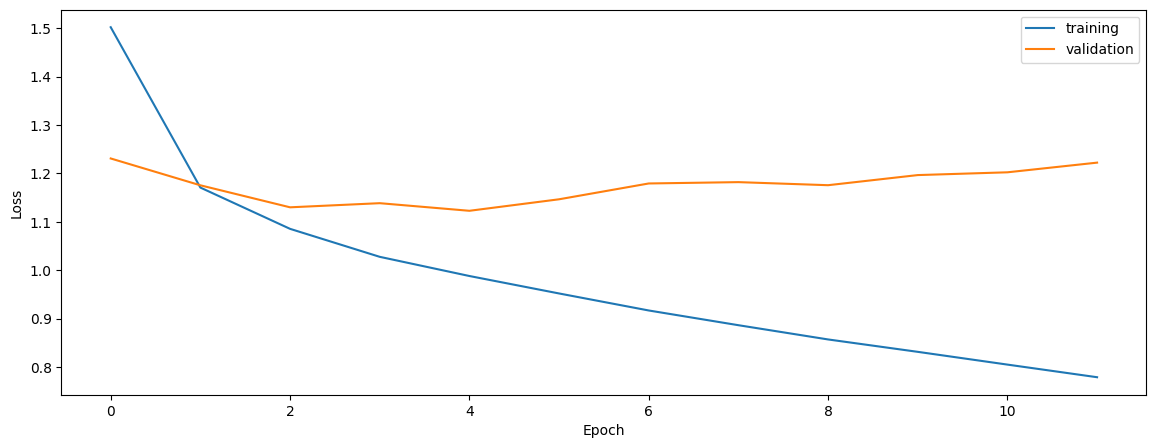

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6244102712308695
0.5526635425460434
0.5541317281931735


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5802357593733364
0.570460413080895
0.5170149644430871


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5806826696984574
0.5632082737374848
0.5191396626871329


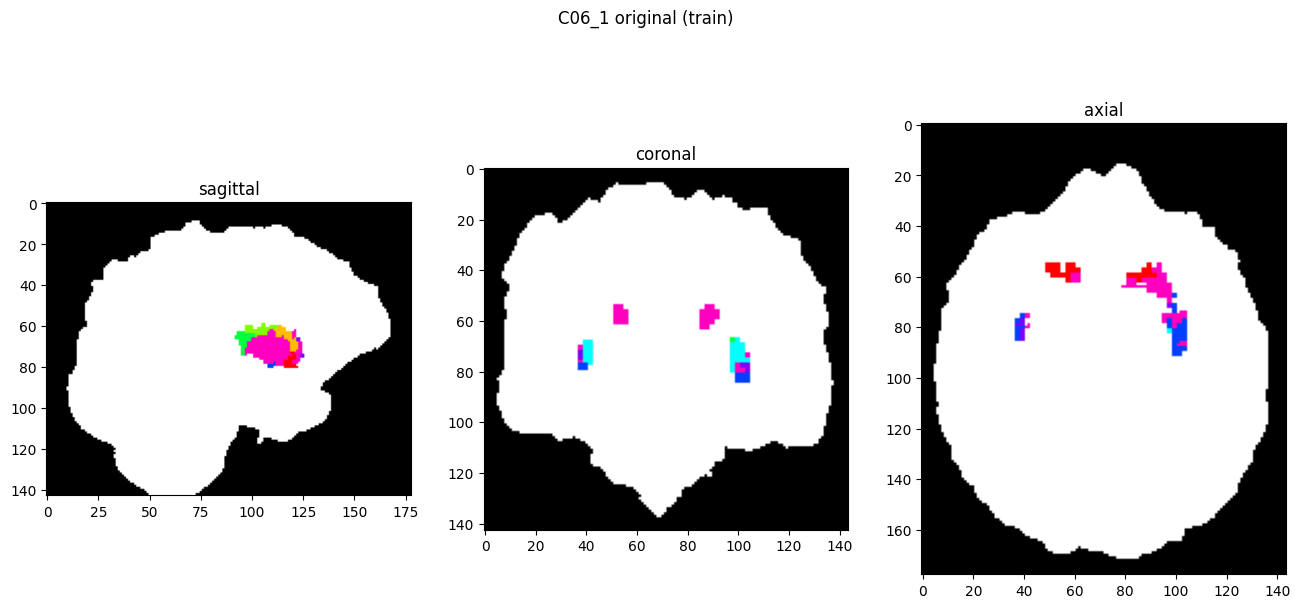

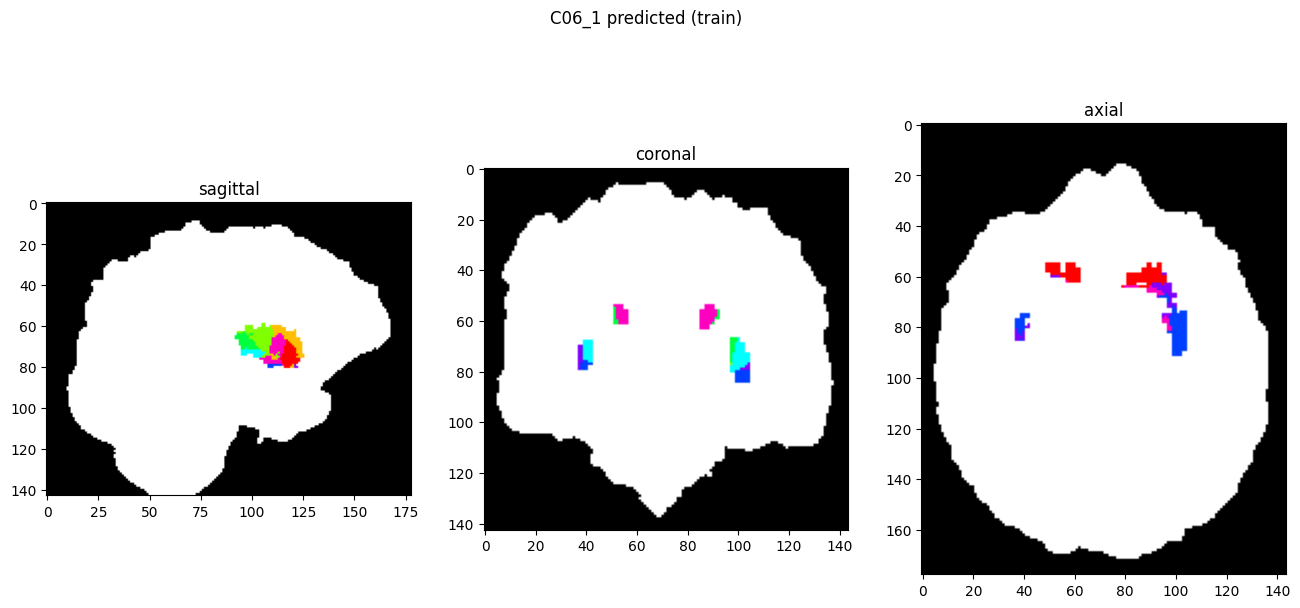

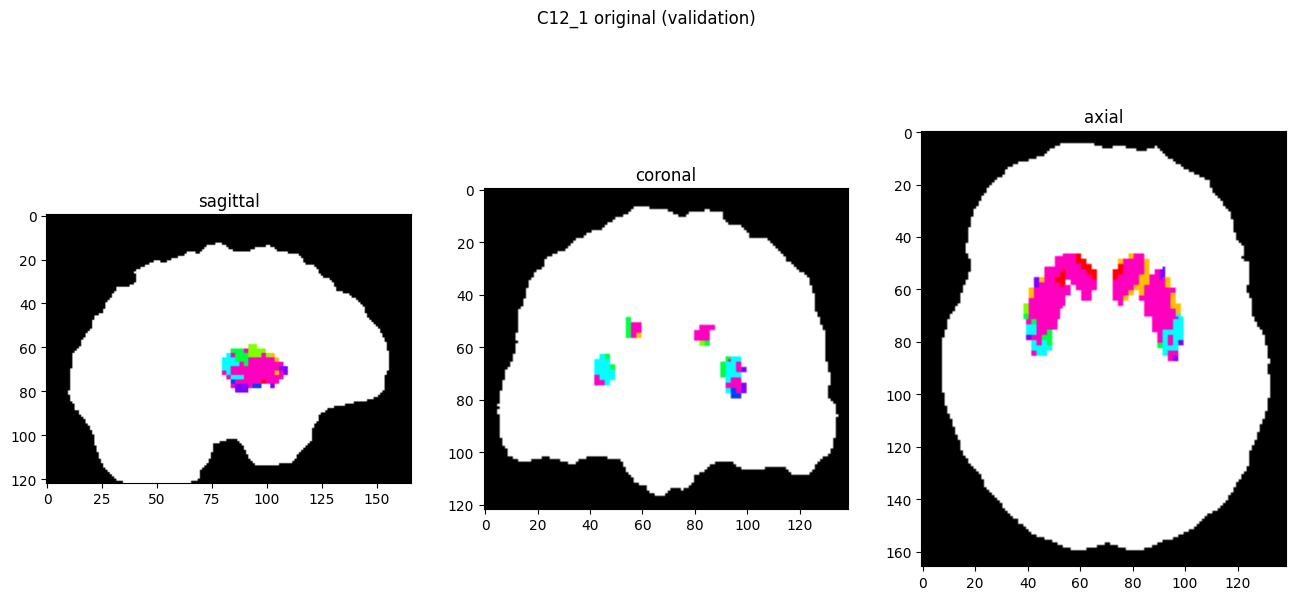

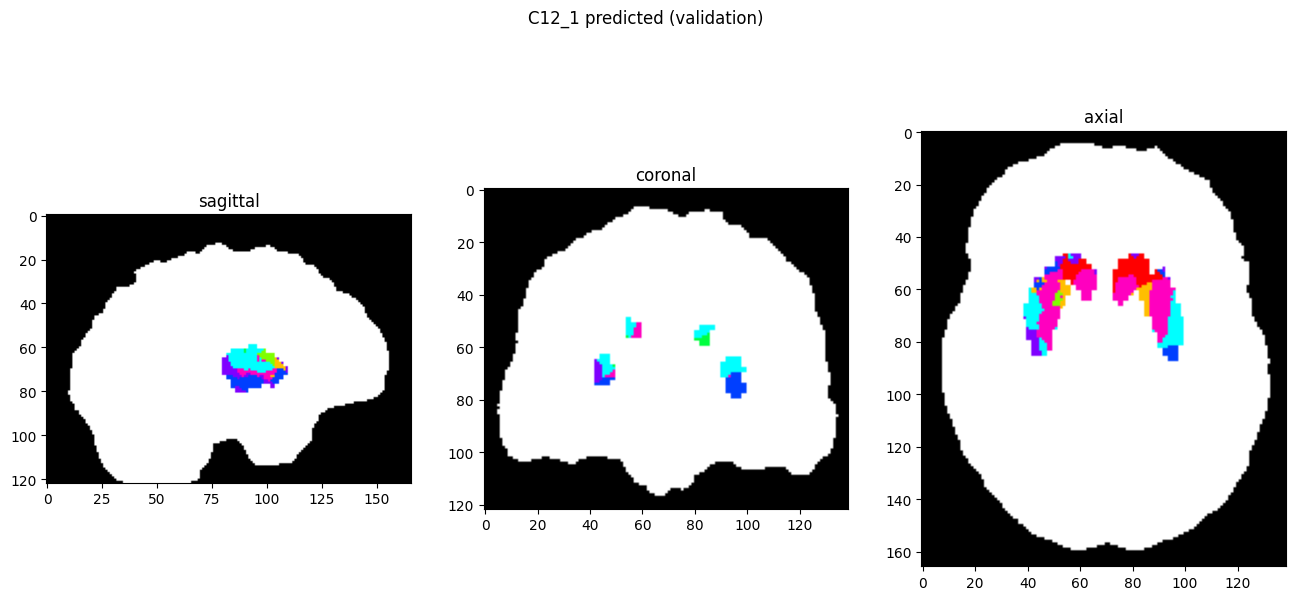

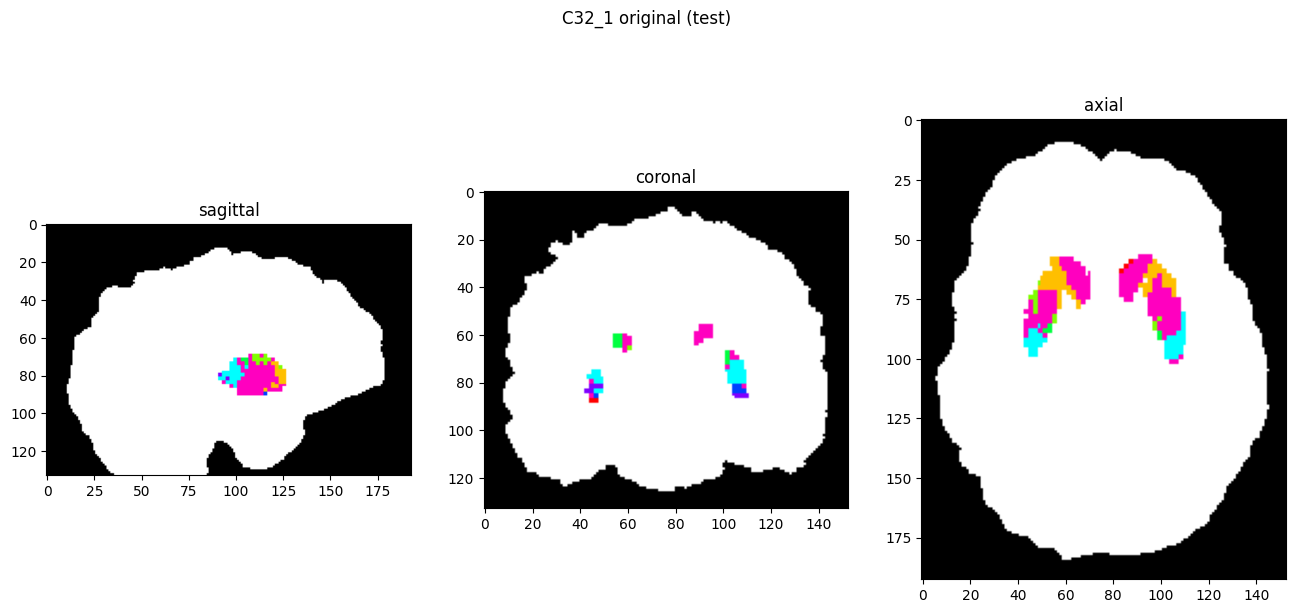

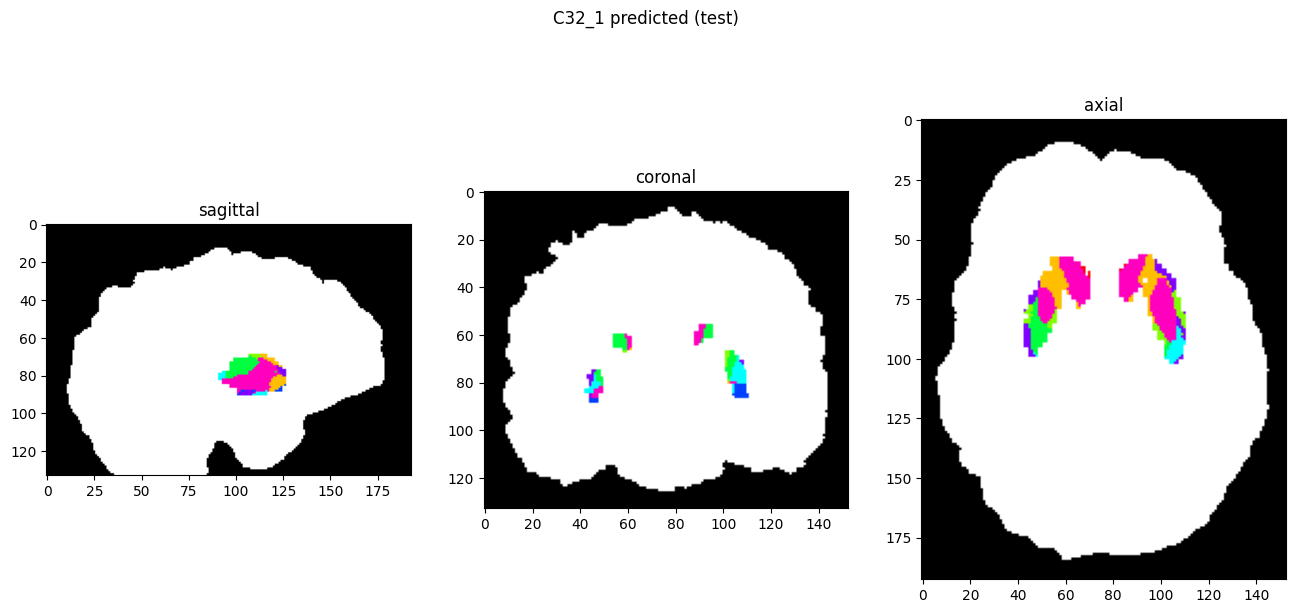

In [10]:
showResults(model, gen, threshold=0)